In [1]:
from collections import defaultdict
import numpy as np
import pandas as pd
import genetools
import scanpy as sc
from IPython.display import display, Markdown
from typing import List, Tuple, Dict
from typing import Optional
import os
import gc
from pathlib import Path

from malid import config, io, logger
from malid.datamodels import GeneLocus, TargetObsColumnEnum, SampleWeightStrategy
from malid.trained_model_wrappers import BlendingMetamodel
from malid.external import model_evaluation
from malid.external.model_evaluation import FeaturizedData
from malid.external.adjust_model_decision_thresholds import (
    AdjustedProbabilitiesDerivedModel,
)
from kdict import kdict
from slugify import slugify

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
gene_loci = config.gene_loci_used
gene_loci

<GeneLocus.BCR|TCR: 3>

In [3]:
metamodel_names = [
    "lasso_cv",
    "ridge_cv",
    "elasticnet_cv",
    "lasso_multiclass",
    "xgboost",
    "linearsvm_ovr",
    "rf_multiclass",
]

In [4]:
evaluation_target = TargetObsColumnEnum.disease
# Also use an alternate evaluation_target that support demographics_only metamodel
evaluation_target_with_demographics = (
    TargetObsColumnEnum.disease_all_demographics_present
)

In [5]:
def list_external_cohort_samples(
    requested_gene_loci: GeneLocus,
    classification_target: TargetObsColumnEnum,
    different_platform: bool,
) -> Optional[pd.DataFrame]:
    """
    Get external cohort entries for a particular gene locus or set of gene loci.
    different_platform: if true, filter ONLY to different sequencing platforms; otherwise filter out different sequencing platforms.
    """
    external_cohort_specimens = pd.read_csv(
        config.paths.metadata_dir / "generated.external_cohorts.all_specimens.tsv",
        sep="\t",
    )
    # The gene_locus field is currently a string name corresponding to a GeneLocus enum
    # Change gene_locus field to be a true GeneLocus object
    external_cohort_specimens["gene_locus"] = external_cohort_specimens[
        "gene_locus"
    ].apply(lambda gene_locus_name: GeneLocus[gene_locus_name])

    ## Find specimens that only have exactly the locus/loci requested, and don't also have data from other loci.
    # The requested_gene_loci flag object may represent a single locus or multiple loci: BCR-only, TCR-only, or BCR+TCR.
    # - If requested gene_locus is BCR, return BCR-only specimens. Don't return specimens that are BCR+TCR.
    # - If requested gene_locus is TCR, return TCR-only specimens. Don't return specimens that are BCR+TCR.
    # - If requested gene_locus is BCR | TCR , return specimens that have BCR and TCR data. Don't return specimens that are only BCR or only TCR.

    # Get gene loci available for each specimen
    loci_for_each_specimen = external_cohort_specimens.groupby("specimen_label")[
        "gene_locus"
    ].unique()

    # keep these: available loci are the same as requested; specimens don't have data from other loci
    specimens_with_data_from_selected_loci = loci_for_each_specimen[
        loci_for_each_specimen.apply(lambda arr: set(arr) == set(requested_gene_loci))
    ].index.tolist()

    # subselect
    external_cohort_specimens = external_cohort_specimens[
        external_cohort_specimens["specimen_label"].isin(
            specimens_with_data_from_selected_loci
        )
    ]

    if external_cohort_specimens.shape[0] == 0:
        # No specimens for desired gene loci
        return None

    ## Other important filter: must exist
    # Get file name
    external_cohort_specimens["fname"] = external_cohort_specimens.apply(
        lambda row: config.paths.external_data_embeddings
        / f"{row['gene_locus'].name}"
        / f"{row['participant_label']}.h5",
        axis=1,
    )
    # Mask
    mask_file_exists = external_cohort_specimens["fname"].apply(os.path.exists)
    if (~mask_file_exists).sum() > 0:
        logger.warning(
            f"Skipping these missing specimens for {requested_gene_loci}: {external_cohort_specimens[~mask_file_exists]['specimen_label_by_locus'].values}"
        )
    # filter down
    external_cohort_specimens = external_cohort_specimens[mask_file_exists]

    ## Also filter out different sequencing platforms
    external_cohort_specimens = external_cohort_specimens[
        external_cohort_specimens["different_platform"] == different_platform
    ]

    # Filter out specimens that don't have demographic data, if requested by this classification_target
    if (
        classification_target.value.require_metadata_columns_present is not None
        and len(classification_target.value.require_metadata_columns_present) > 0
    ):
        # Filter out rows with obs[required_metadata_cols] has any NaNs
        external_cohort_specimens = external_cohort_specimens.loc[
            ~external_cohort_specimens[
                classification_target.value.require_metadata_columns_present
            ]
            .isna()
            .any(axis=1)
        ]

    if external_cohort_specimens.shape[0] == 0:
        # No specimens for desired gene loci
        return None

    return external_cohort_specimens

In [6]:
def load_external_cohort_anndatas(
    external_cohort_specimens: pd.DataFrame,
    sample_weight_strategy: SampleWeightStrategy = SampleWeightStrategy.ISOTYPE_USAGE,
):
    """Generator yielding external cohort participant anndatas"""
    # the data is stored as one embedded anndata per locus per participant (i.e. can have multiple specimens)
    for participant_label, grp in external_cohort_specimens.groupby(
        "participant_label", observed=True
    ):
        adatas_by_locus: Dict[GeneLocus, anndata.AnnData] = {}
        # subselect to one file name per locus per participant (that's all that is available)
        filename_by_locus: Dict[GeneLocus, List[str]] = (
            grp.groupby("gene_locus", sort=False)["fname"].unique().to_dict()
        )
        for gene_locus, fname_lst in filename_by_locus.items():
            assert (
                len(fname_lst) == 1
            ), "should only have one unique filename per participant per locus"
            fname = fname_lst[0]

            adata = sc.read(fname)
            adata.obs = adata.obs.assign(fold_id=-1, fold_label="external")

            # produces 'disease.separate_past_exposures' obs column.
            adata = io.label_past_exposures(adata)
            adata = io.fix_gene_names(adata)

            # load sequence weights for off-peak too
            if sample_weight_strategy == SampleWeightStrategy.ISOTYPE_USAGE:
                # calculate sample weights to balance out isotype proportions for each specimen
                adata.obs = genetools.helpers.merge_into_left(
                    adata.obs,
                    io.compute_isotype_sample_weights_column(adata).rename(
                        "sample_weight_isotype_rebalance"
                    ),
                )

            # Add demographics
            for colname in ["age", "sex", "ethnicity_condensed"]:
                # should be same for all specimens for this participant
                adata.obs[colname] = grp[colname].iloc[0]

            adatas_by_locus[gene_locus] = adata

        # For each participant, yield Tuple[participant_label string, Dict[GeneLocus, anndata.AnnData]]
        yield participant_label, adatas_by_locus

In [7]:
def run(
    gene_locus: GeneLocus,
    different_platform: bool,
    classification_target: TargetObsColumnEnum,
    output_dir: Optional[Path] = None,
    metamodel_flavor: str = "default",
) -> Tuple[model_evaluation.ExperimentSetGlobalPerformance, Dict[str, FeaturizedData]]:
    """Load and run metamodel for a single locus or multiple loci"""
    display(Markdown(f"## {gene_locus}"))

    external_cohort_specimens = list_external_cohort_samples(
        requested_gene_loci=gene_locus,
        classification_target=classification_target,
        different_platform=different_platform,
    )
    if external_cohort_specimens is None or external_cohort_specimens.shape[0] == 0:
        logger.warning(f"No external cohort specimens found for {gene_locus}")
        return None, None

    # Final result containers, for all metamodels
    results = model_evaluation.ExperimentSet()
    featurized_by_metamodel_name = {}

    # Load the metamodels
    clfs = {}
    for metamodel_name in metamodel_names:
        clfs[metamodel_name] = BlendingMetamodel.from_disk(
            fold_id=-1,
            metamodel_name=metamodel_name,
            base_model_train_fold_name="train_smaller",
            metamodel_fold_label_train="validation",
            gene_locus=gene_locus,
            target_obs_column=classification_target,
            metamodel_flavor=metamodel_flavor,
        )

    # Load data and featurize.
    # Store a List[FeaturizedData] per metamodel. (TODO: is this necessary? aren't the featurizations all going to be the same?)
    featurized_lists_per_metamodel: Dict[str, List[FeaturizedData]] = defaultdict(list)
    for participant_label, adata_by_locus in load_external_cohort_anndatas(
        external_cohort_specimens=external_cohort_specimens
    ):
        for metamodel_name, clf in clfs.items():
            # Featurize one participant.
            # (external cohort is too big to create an anndata with all participants)

            # adata_by_locus has input anndatas wrapped as Dict[GeneLocus, anndata.AnnData],
            # allowing use of single-locus or multi-locus metamodel.
            featurized_lists_per_metamodel[metamodel_name].append(
                clf.featurize(adata_by_locus)
            )

        # garbage collect
        del adata_by_locus
        gc.collect()

    ## Split out some featurized data for optional decision threshold tuning (old, ignore this, just use the "untuned.all_data" results.)

    # All FeaturizedData lists in featurized_lists_per_metamodel are ordered consistently between metamodels,
    # so we can use any to determine the split indices:
    one_featurized_list: List[FeaturizedData] = next(
        iter(featurized_lists_per_metamodel.values())
    )

    # Each participant has one FeaturizedData object,
    # though some participants may have multiple specimens (i.e. the single merged FeaturizedData object has shape[0] > 1),
    # and some participants may have no specimens due to abstention (i.e. the object has shape[0] == 0).

    # Sanity checks:
    # Each FeaturizedData has only a single unique participant label (or is empty due to abstentions)
    assert all(
        featurized.metadata["participant_label"].nunique() == 1
        or featurized.metadata.shape[0] == 0
        for featurized in one_featurized_list
    )
    # In the case of participants with multiple specimens: confirm they have been merged at this point
    participant_label_of_each = [
        featurized.metadata.iloc[0]["participant_label"]
        for featurized in one_featurized_list
        if featurized.y.shape[0] > 0
    ]
    assert len(participant_label_of_each) == len(
        set(participant_label_of_each)
    ), "Same participant label shared by multiple entries in featurized_list"

    # Get y label of each featurized object
    disease_label_of_each = [
        featurized.y[0] if featurized.y.shape[0] > 0 else None
        for featurized in one_featurized_list
    ]

    # Choose how many we will split off for validation. Take 30% of smallest class (measured by # unique patients) - constrained to be between 2 to 10 samples per class.
    amount_to_take = int(
        min(
            max(
                0.3 * pd.Series(disease_label_of_each).dropna().value_counts().min(), 2
            ),
            10,
        )
    )
    logger.info(
        f"{gene_locus}, {classification_target}, metamodel flavor {metamodel_flavor}: splitting off {amount_to_take} participants per class for decision threshold tuning."
    )

    # Get indices for each disease. We want to choose the same number per disease.
    indices_per_disease = {
        disease: [
            ix for ix, label in enumerate(disease_label_of_each) if label == disease
        ]
        for disease in pd.Series(disease_label_of_each).dropna().unique()
    }

    # Split off some validation from remaining test
    indices_per_disease = {
        disease: (indices[:amount_to_take], indices[amount_to_take:])
        for disease, indices in indices_per_disease.items()
    }
    indices_validation_all = np.hstack(
        [
            validation_indices
            for disease, (
                validation_indices,
                test_indices,
            ) in indices_per_disease.items()
        ]
    )
    indices_test_all = np.hstack(
        [
            test_indices
            for disease, (
                validation_indices,
                test_indices,
            ) in indices_per_disease.items()
        ]
    )
    # Add abstention indices to indices_test_all
    indices_test_all = np.hstack(
        [indices_test_all, np.where(pd.Series(disease_label_of_each).isna())[0]]
    )

    # sanity check
    assert len(set(indices_validation_all).intersection(set(indices_test_all))) == 0
    assert (
        len(indices_test_all) + len(indices_validation_all)
        == len(disease_label_of_each)
        == len(one_featurized_list)
    )

    ## Run each metamodel
    for metamodel_name in metamodel_names:
        featurized_list = featurized_lists_per_metamodel[metamodel_name]
        clf = clfs[metamodel_name]

        # Combine featurized_list in a few different ways:
        # - combine all
        featurized_all: FeaturizedData = FeaturizedData.concat(featurized_list)
        # - combine validation subset
        featurized_validation: FeaturizedData = FeaturizedData.concat(
            [featurized_list[ix] for ix in indices_validation_all]
        )
        # - combine test subset
        featurized_test: FeaturizedData = FeaturizedData.concat(
            [featurized_list[ix] for ix in indices_test_all]
        )

        # Handle abstention
        if (
            featurized_all.X.shape[0] == 0
            or featurized_validation.X.shape[0] == 0
            or featurized_test.X.shape[0] == 0
        ):
            raise ValueError("All abstained")

        # Tune model
        clf_tuned = AdjustedProbabilitiesDerivedModel.adjust_model_decision_thresholds(
            model=clf,
            X_validation=featurized_validation.X,
            y_validation_true=featurized_validation.y,
        )

        # Do evaluation
        for transformed_clf, transformed_model_name, featurized in zip(
            [clf, clf, clf_tuned],
            [
                metamodel_name + ".untuned.all_data",
                metamodel_name + ".untuned.test_subset",
                metamodel_name + ".tuned.test_subset",
            ],
            [featurized_all, featurized_test, featurized_test],
        ):
            results.add(
                model_evaluation.ModelSingleFoldPerformance(
                    model_name=transformed_model_name,
                    fold_id=-1,
                    y_true=featurized.y,
                    clf=transformed_clf,
                    X_test=featurized.X,
                    fold_label_train="train_smaller",
                    fold_label_test="external",
                    test_metadata=featurized.metadata,
                    test_abstentions=featurized.abstained_sample_y,
                    test_abstention_metadata=featurized.abstained_sample_metadata,
                )
            )
            featurized_by_metamodel_name[transformed_model_name] = featurized

    results = results.summarize()
    combined_stats = results.get_model_comparison_stats(sort=True)

    if output_dir is not None:
        output_dir.mkdir(parents=True, exist_ok=True)
        results.export_all_models(
            func_generate_classification_report_fname=lambda model_name: output_dir
            / f"classification_report.{model_name}.txt",
            func_generate_confusion_matrix_fname=lambda model_name: output_dir
            / f"confusion_matrix.{model_name}.png",
            dpi=300,
        )
        combined_stats.to_csv(
            output_dir / "compare_model_scores.tsv",
            sep="\t",
        )

    display(combined_stats)
    for model_name, model_perf in results.model_global_performances.items():
        print(model_name)
        print(model_perf.full_report())
        display(model_perf.confusion_matrix_fig())
        print()
        print("*" * 60)
        print()

    return results, featurized_by_metamodel_name

# External cohorts similar to our sequencing process

## GeneLocus.BCR

2023-01-05 08:30:03,852 - evaluate_external_cohorts.ipynb - WARNING - Skipping these missing specimens for GeneLocus.BCR: ['5578047616589173226-242ac116-0001-012'
 '5594669140024693226-242ac116-0001-012'
 '5549400184724853226-242ac116-0001-012'
 '5563272929090933226-242ac116-0001-012'
 '6199958881049973226-242ac116-0001-012'
 '6219758680284533226-242ac116-0001-012'
 '6162506766228853226-242ac116-0001-012'
 '6180202031488373226-242ac116-0001-012'
 '6272329079987573226-242ac116-0001-012'
 '6286545421737333226-242ac116-0001-012'
 '6235177612877173226-242ac116-0001-012'
 '6255707556552053226-242ac116-0001-012'
 '6333961860685173226-242ac116-0001-012'
 '6347448057994613226-242ac116-0001-012'
 '6301749605965173226-242ac116-0001-012'
 '6318371129400693226-242ac116-0001-012'
 '6392545214602613226-242ac116-0001-012'
 '6410541127572853226-242ac116-0001-012'
 '6361063104322933226-242ac116-0001-012'
 '6374978798361973226-242ac116-0001-012'
 '6458344113577333226-242ac116-0001-012'
 '647256045532709

,ROC-AUC (weighted OvO) per fold,ROC-AUC (macro OvO) per fold,au-PRC (weighted OvO) per fold,au-PRC (macro OvO) per fold,Accuracy per fold,MCC per fold,Accuracy global,MCC global,sample_size,n_abstentions,sample_size including abstentions,abstention_rate,missing_classes
lasso_cv.untuned.all_data,1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),0.923 +/- 0.000 (in 1 folds),0.867 +/- 0.000 (in 1 folds),0.923,0.867,13,0,13,0.0,False
lasso_multiclass.tuned.test_subset,1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000,1.000,9,0,9,0.0,False
rf_multiclass.untuned.test_subset,1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000,1.000,9,0,9,0.0,False
rf_multiclass.untuned.all_data,1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000,1.000,13,0,13,0.0,False
linearsvm_ovr.tuned.test_subset,1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000,1.000,9,0,9,0.0,False
linearsvm_ovr.untuned.test_subset,1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000,1.000,9,0,9,0.0,False
linearsvm_ovr.untuned.all_data,1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000,1.000,13,0,13,0.0,False
xgboost.tuned.test_subset,1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),0.889 +/- 0.000 (in 1 folds),0.800 +/- 0.000 (in 1 folds),0.889,0.800,9,0,9,0.0,False
xgboost.untuned.test_subset,1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),0.889 +/- 0.000 (in 1 folds),0.800 +/- 0.000 (in 1 folds),0.889,0.800,9,0,9,0.0,False
xgboost.untuned.all_data,1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),0.923 +/- 0.000 (in 1 folds),0.857 +/- 0.000 (in 1 folds),0.923,0.857,13,0,13,0.0,False


lasso_cv.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 0.923 +/- 0.000 (in 1 folds)
MCC: 0.867 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.923
MCC: 0.867

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      1.00      1.00         7
Healthy/Background       1.00      0.83      0.91         6
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.92        13
         macro avg       0.67      0.61      0.64        13
      weighted avg       1.00      0.92      0.96        13



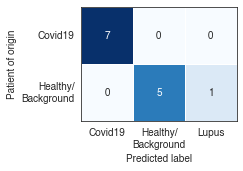


************************************************************

lasso_cv.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 0.889 +/- 0.000 (in 1 folds)
MCC: 0.816 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.889
MCC: 0.816

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      1.00      1.00         5
Healthy/Background       1.00      0.75      0.86         4
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.89         9
         macro avg       0.67      0.58      0.62         9
      weighted avg       1.00      0.89      0.94         9



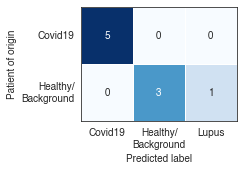


************************************************************

lasso_cv.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 0.889 +/- 0.000 (in 1 folds)
MCC: 0.816 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.889
MCC: 0.816

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      1.00      1.00         5
Healthy/Background       1.00      0.75      0.86         4
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.89         9
         macro avg       0.67      0.58      0.62         9
      weighted avg       1.00      0.89      0.94         9



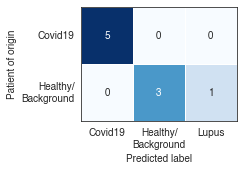


************************************************************

ridge_cv.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.929 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.929 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.931 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.931 +/- 0.000 (in 1 folds)
Accuracy: 0.615 +/- 0.000 (in 1 folds)
MCC: 0.395 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.615
MCC: 0.395

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.29      0.44         7
Healthy/Background       0.55      1.00      0.71         6

          accuracy                           0.62        13
         macro avg       0.77      0.64      0.58        13
      weighted avg       0.79      0.62      0.57        13



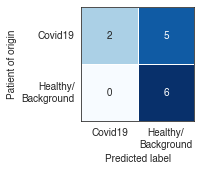


************************************************************

ridge_cv.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.950 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.950 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.950 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.950 +/- 0.000 (in 1 folds)
Accuracy: 0.556 +/- 0.000 (in 1 folds)
MCC: 0.316 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.556
MCC: 0.316

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.20      0.33         5
Healthy/Background       0.50      1.00      0.67         4

          accuracy                           0.56         9
         macro avg       0.75      0.60      0.50         9
      weighted avg       0.78      0.56      0.48         9



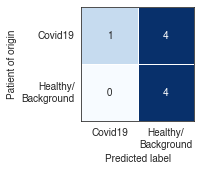


************************************************************

ridge_cv.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.950 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.950 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.950 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.950 +/- 0.000 (in 1 folds)
Accuracy: 1.000 +/- 0.000 (in 1 folds)
MCC: 1.000 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 1.000
MCC: 1.000

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      1.00      1.00         5
Healthy/Background       1.00      1.00      1.00         4

          accuracy                           1.00         9
         macro avg       1.00      1.00      1.00         9
      weighted avg       1.00      1.00      1.00         9



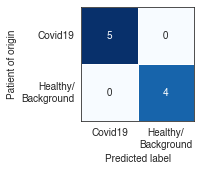


************************************************************

elasticnet_cv.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 1.000 +/- 0.000 (in 1 folds)
MCC: 1.000 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 1.000
MCC: 1.000

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      1.00      1.00         7
Healthy/Background       1.00      1.00      1.00         6

          accuracy                           1.00        13
         macro avg       1.00      1.00      1.00        13
      weighted avg       1.00      1.00      1.00        13



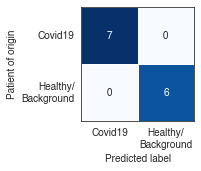


************************************************************

elasticnet_cv.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 1.000 +/- 0.000 (in 1 folds)
MCC: 1.000 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 1.000
MCC: 1.000

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      1.00      1.00         5
Healthy/Background       1.00      1.00      1.00         4

          accuracy                           1.00         9
         macro avg       1.00      1.00      1.00         9
      weighted avg       1.00      1.00      1.00         9



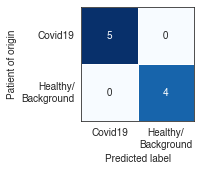


************************************************************

elasticnet_cv.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 0.889 +/- 0.000 (in 1 folds)
MCC: 0.800 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.889
MCC: 0.800

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.80      0.89         5
Healthy/Background       0.80      1.00      0.89         4

          accuracy                           0.89         9
         macro avg       0.90      0.90      0.89         9
      weighted avg       0.91      0.89      0.89         9



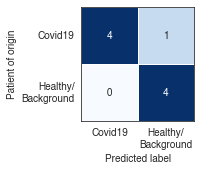


************************************************************

lasso_multiclass.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 1.000 +/- 0.000 (in 1 folds)
MCC: 1.000 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 1.000
MCC: 1.000

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      1.00      1.00         7
Healthy/Background       1.00      1.00      1.00         6

          accuracy                           1.00        13
         macro avg       1.00      1.00      1.00        13
      weighted avg       1.00      1.00      1.00        13



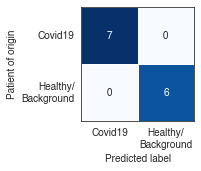


************************************************************

lasso_multiclass.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 1.000 +/- 0.000 (in 1 folds)
MCC: 1.000 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 1.000
MCC: 1.000

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      1.00      1.00         5
Healthy/Background       1.00      1.00      1.00         4

          accuracy                           1.00         9
         macro avg       1.00      1.00      1.00         9
      weighted avg       1.00      1.00      1.00         9



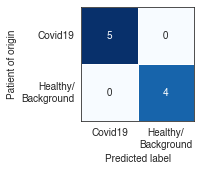


************************************************************

lasso_multiclass.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 1.000 +/- 0.000 (in 1 folds)
MCC: 1.000 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 1.000
MCC: 1.000

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      1.00      1.00         5
Healthy/Background       1.00      1.00      1.00         4

          accuracy                           1.00         9
         macro avg       1.00      1.00      1.00         9
      weighted avg       1.00      1.00      1.00         9



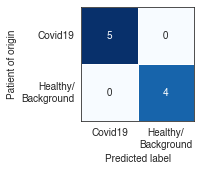


************************************************************

xgboost.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 0.923 +/- 0.000 (in 1 folds)
MCC: 0.857 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.923
MCC: 0.857

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.86      0.92         7
Healthy/Background       0.86      1.00      0.92         6

          accuracy                           0.92        13
         macro avg       0.93      0.93      0.92        13
      weighted avg       0.93      0.92      0.92        13



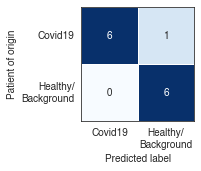


************************************************************

xgboost.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 0.889 +/- 0.000 (in 1 folds)
MCC: 0.800 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.889
MCC: 0.800

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.80      0.89         5
Healthy/Background       0.80      1.00      0.89         4

          accuracy                           0.89         9
         macro avg       0.90      0.90      0.89         9
      weighted avg       0.91      0.89      0.89         9



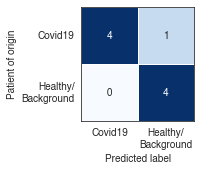


************************************************************

xgboost.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 0.889 +/- 0.000 (in 1 folds)
MCC: 0.800 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.889
MCC: 0.800

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.80      0.89         5
Healthy/Background       0.80      1.00      0.89         4

          accuracy                           0.89         9
         macro avg       0.90      0.90      0.89         9
      weighted avg       0.91      0.89      0.89         9



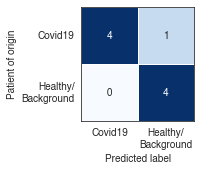


************************************************************

linearsvm_ovr.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 1.000 +/- 0.000 (in 1 folds)
MCC: 1.000 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 1.000
MCC: 1.000

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      1.00      1.00         7
Healthy/Background       1.00      1.00      1.00         6

          accuracy                           1.00        13
         macro avg       1.00      1.00      1.00        13
      weighted avg       1.00      1.00      1.00        13



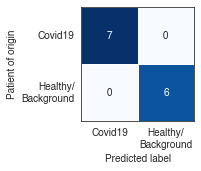


************************************************************

linearsvm_ovr.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 1.000 +/- 0.000 (in 1 folds)
MCC: 1.000 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 1.000
MCC: 1.000

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      1.00      1.00         5
Healthy/Background       1.00      1.00      1.00         4

          accuracy                           1.00         9
         macro avg       1.00      1.00      1.00         9
      weighted avg       1.00      1.00      1.00         9



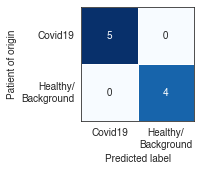


************************************************************

linearsvm_ovr.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 1.000 +/- 0.000 (in 1 folds)
MCC: 1.000 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 1.000
MCC: 1.000

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      1.00      1.00         5
Healthy/Background       1.00      1.00      1.00         4

          accuracy                           1.00         9
         macro avg       1.00      1.00      1.00         9
      weighted avg       1.00      1.00      1.00         9



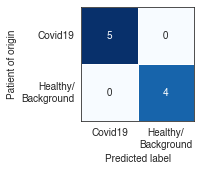


************************************************************

rf_multiclass.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 1.000 +/- 0.000 (in 1 folds)
MCC: 1.000 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 1.000
MCC: 1.000

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      1.00      1.00         7
Healthy/Background       1.00      1.00      1.00         6

          accuracy                           1.00        13
         macro avg       1.00      1.00      1.00        13
      weighted avg       1.00      1.00      1.00        13



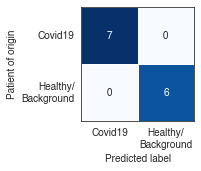


************************************************************

rf_multiclass.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 1.000 +/- 0.000 (in 1 folds)
MCC: 1.000 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 1.000
MCC: 1.000

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      1.00      1.00         5
Healthy/Background       1.00      1.00      1.00         4

          accuracy                           1.00         9
         macro avg       1.00      1.00      1.00         9
      weighted avg       1.00      1.00      1.00         9



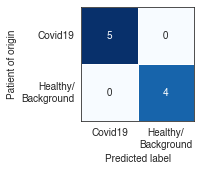


************************************************************

rf_multiclass.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 1.000 +/- 0.000 (in 1 folds)
MCC: 1.000 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 1.000
MCC: 1.000

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      1.00      1.00         5
Healthy/Background       1.00      1.00      1.00         4

          accuracy                           1.00         9
         macro avg       1.00      1.00      1.00         9
      weighted avg       1.00      1.00      1.00         9



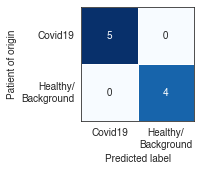


************************************************************



## GeneLocus.TCR

2023-01-05 08:46:34,989 - evaluate_external_cohorts.ipynb - WARNING - Skipping these missing specimens for GeneLocus.TCR: ['P00311' 'P00104' 'P00511' 'Keck0013_MC1' 'P00599' 'P00130'
 'Keck0099_MC1' 'P00415' 'P00583' 'P00534' 'P00407' 'P00513'
 'Keck0081_MC1' 'P00644' 'P00174' 'P00432' 'P00381' 'Keck0082_MC1'
 'P00167' 'P00554' 'P00606' 'P00368' 'P00203' 'Keck0007_MC1' 'P00414'
 'Keck0036_MC1' 'P00530' 'P00030' 'Keck0088_MC1' 'P00334' 'P00587'
 'P00395' 'Keck0015_MC1' 'P00056' 'P00095' 'P00156' 'P00032' 'P00520'
 'P00387' 'P00299' 'P00384' 'P00548' 'P00422' 'P00198' 'P00085' 'P00596'
 'P00400' 'P00039' 'P00128' 'P00589' 'P00592' 'P00172' 'P00161' 'P00102'
 'P00425' 'P00537' 'P00458' 'P00624' 'Keck0011_MC1' 'P00551' 'P00569'
 'P00036' 'Keck0083_MC1' 'P00642' 'P00107' 'P00223' 'P00159' 'P00047'
 'Keck0070_MC1' 'Keck0074_MC1' 'P00046' 'P00126' 'P00631' 'P00597'
 'P00616' 'P00471' 'P00224' 'P00075' 'P00539' 'Keck0040_MC1' 'P00433'
 'Keck0017_MC1' 'P00178' 'P00037' 'Keck0003_MC1' 'P00197' '

,ROC-AUC (weighted OvO) per fold,ROC-AUC (macro OvO) per fold,au-PRC (weighted OvO) per fold,au-PRC (macro OvO) per fold,Accuracy per fold,MCC per fold,Accuracy global,MCC global,sample_size,n_abstentions,sample_size including abstentions,abstention_rate,missing_classes
lasso_multiclass.untuned.test_subset,1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),0.739 +/- 0.000 (in 1 folds),0.546 +/- 0.000 (in 1 folds),0.739,0.546,46,0,46,0.0,False
elasticnet_cv.untuned.test_subset,1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),0.848 +/- 0.000 (in 1 folds),0.661 +/- 0.000 (in 1 folds),0.848,0.661,46,0,46,0.0,False
rf_multiclass.untuned.test_subset,1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),0.913 +/- 0.000 (in 1 folds),0.802 +/- 0.000 (in 1 folds),0.913,0.802,46,0,46,0.0,False
lasso_multiclass.tuned.test_subset,1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),0.739 +/- 0.000 (in 1 folds),0.480 +/- 0.000 (in 1 folds),0.739,0.480,46,0,46,0.0,False
lasso_cv.untuned.test_subset,1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),0.826 +/- 0.000 (in 1 folds),0.601 +/- 0.000 (in 1 folds),0.826,0.601,46,0,46,0.0,False
elasticnet_cv.tuned.test_subset,1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),0.957 +/- 0.000 (in 1 folds),0.889 +/- 0.000 (in 1 folds),0.957,0.889,46,0,46,0.0,False
rf_multiclass.tuned.test_subset,1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),0.891 +/- 0.000 (in 1 folds),0.716 +/- 0.000 (in 1 folds),0.891,0.716,46,0,46,0.0,False
ridge_cv.tuned.test_subset,1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),0.935 +/- 0.000 (in 1 folds),0.832 +/- 0.000 (in 1 folds),0.935,0.832,46,0,46,0.0,False
ridge_cv.untuned.test_subset,1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),0.739 +/- 0.000 (in 1 folds),0.524 +/- 0.000 (in 1 folds),0.739,0.524,46,0,46,0.0,False
lasso_cv.tuned.test_subset,1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),0.826 +/- 0.000 (in 1 folds),0.601 +/- 0.000 (in 1 folds),0.826,0.601,46,0,46,0.0,False


lasso_cv.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.997 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.997 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.999 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.999 +/- 0.000 (in 1 folds)
Accuracy: 0.804 +/- 0.000 (in 1 folds)
MCC: 0.601 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.804
MCC: 0.601

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.35      0.52        17
Healthy/Background       0.93      1.00      0.96        39
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.80        56
         macro avg       0.64      0.45      0.49        56
      weighted avg       0.95      0.80      0.83        56



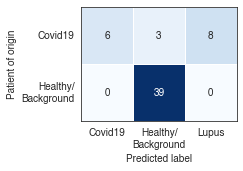


************************************************************

lasso_cv.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 0.826 +/- 0.000 (in 1 folds)
MCC: 0.601 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.826
MCC: 0.601

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.33      0.50        12
Healthy/Background       0.94      1.00      0.97        34
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.83        46
         macro avg       0.65      0.44      0.49        46
      weighted avg       0.96      0.83      0.85        46



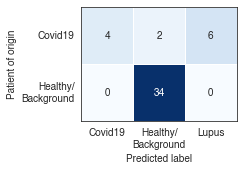


************************************************************

lasso_cv.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 0.826 +/- 0.000 (in 1 folds)
MCC: 0.601 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.826
MCC: 0.601

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.33      0.50        12
Healthy/Background       0.94      1.00      0.97        34
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.83        46
         macro avg       0.65      0.44      0.49        46
      weighted avg       0.96      0.83      0.85        46



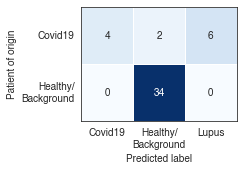


************************************************************

ridge_cv.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.994 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.994 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.997 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.997 +/- 0.000 (in 1 folds)
Accuracy: 0.732 +/- 0.000 (in 1 folds)
MCC: 0.536 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.732
MCC: 0.536

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.29      0.45        17
Healthy/Background       0.97      0.92      0.95        39
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.73        56
         macro avg       0.66      0.41      0.47        56
      weighted avg       0.98      0.73      0.80        56



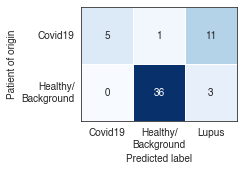


************************************************************

ridge_cv.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 0.739 +/- 0.000 (in 1 folds)
MCC: 0.524 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.739
MCC: 0.524

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.25      0.40        12
Healthy/Background       1.00      0.91      0.95        34
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.74        46
         macro avg       0.67      0.39      0.45        46
      weighted avg       1.00      0.74      0.81        46



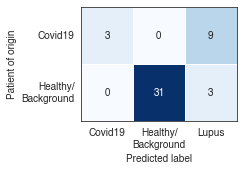


************************************************************

ridge_cv.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 0.935 +/- 0.000 (in 1 folds)
MCC: 0.832 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.935
MCC: 0.832

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.75      0.86        12
Healthy/Background       0.94      1.00      0.97        34
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.93        46
         macro avg       0.65      0.58      0.61        46
      weighted avg       0.96      0.93      0.94        46



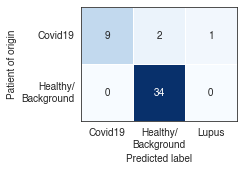


************************************************************

elasticnet_cv.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.998 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.998 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.999 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.999 +/- 0.000 (in 1 folds)
Accuracy: 0.821 +/- 0.000 (in 1 folds)
MCC: 0.643 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.821
MCC: 0.643

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.41      0.58        17
Healthy/Background       0.95      1.00      0.97        39
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.82        56
         macro avg       0.65      0.47      0.52        56
      weighted avg       0.97      0.82      0.86        56



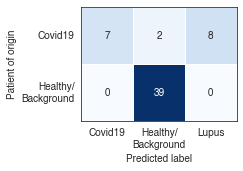


************************************************************

elasticnet_cv.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 0.848 +/- 0.000 (in 1 folds)
MCC: 0.661 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.848
MCC: 0.661

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.42      0.59        12
Healthy/Background       0.97      1.00      0.99        34
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.85        46
         macro avg       0.66      0.47      0.52        46
      weighted avg       0.98      0.85      0.88        46



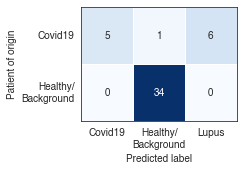


************************************************************

elasticnet_cv.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 0.957 +/- 0.000 (in 1 folds)
MCC: 0.889 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.957
MCC: 0.889

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.83      0.91        12
Healthy/Background       0.97      1.00      0.99        34
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.96        46
         macro avg       0.66      0.61      0.63        46
      weighted avg       0.98      0.96      0.97        46



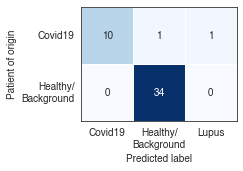


************************************************************

lasso_multiclass.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.979 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.979 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.992 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.992 +/- 0.000 (in 1 folds)
Accuracy: 0.679 +/- 0.000 (in 1 folds)
MCC: 0.464 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.679
MCC: 0.464

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.48      0.82      0.61        17
Healthy/Background       1.00      0.62      0.76        39
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.68        56
         macro avg       0.49      0.48      0.46        56
      weighted avg       0.84      0.68      0.72        56



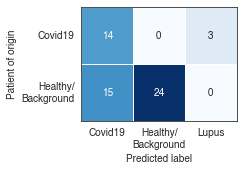


************************************************************

lasso_multiclass.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 0.739 +/- 0.000 (in 1 folds)
MCC: 0.546 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.739
MCC: 0.546

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.50      0.92      0.65        12
Healthy/Background       1.00      0.68      0.81        34
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.74        46
         macro avg       0.50      0.53      0.48        46
      weighted avg       0.87      0.74      0.77        46



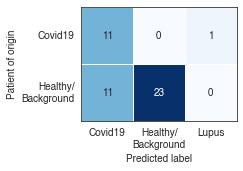


************************************************************

lasso_multiclass.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 0.739 +/- 0.000 (in 1 folds)
MCC: 0.480 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.739
MCC: 0.480

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00        12
               HIV       0.00      0.00      0.00         0
Healthy/Background       1.00      1.00      1.00        34
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.74        46
         macro avg       0.25      0.25      0.25        46
      weighted avg       0.74      0.74      0.74        46



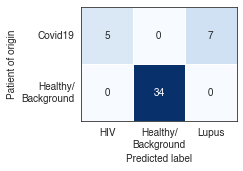


************************************************************

xgboost.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.988 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.988 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.995 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.995 +/- 0.000 (in 1 folds)
Accuracy: 0.750 +/- 0.000 (in 1 folds)
MCC: 0.534 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.750
MCC: 0.534

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.18      0.30        17
Healthy/Background       0.95      1.00      0.97        39
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.75        56
         macro avg       0.65      0.39      0.42        56
      weighted avg       0.97      0.75      0.77        56



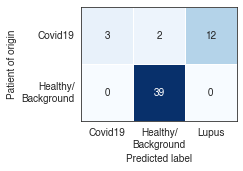


************************************************************

xgboost.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.998 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.998 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.999 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.999 +/- 0.000 (in 1 folds)
Accuracy: 0.761 +/- 0.000 (in 1 folds)
MCC: 0.508 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.761
MCC: 0.508

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.08      0.15        12
Healthy/Background       0.97      1.00      0.99        34
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.76        46
         macro avg       0.66      0.36      0.38        46
      weighted avg       0.98      0.76      0.77        46



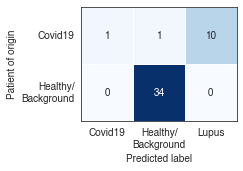


************************************************************

xgboost.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.998 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.998 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.999 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.999 +/- 0.000 (in 1 folds)
Accuracy: 0.761 +/- 0.000 (in 1 folds)
MCC: 0.508 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.761
MCC: 0.508

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.08      0.15        12
Healthy/Background       0.97      1.00      0.99        34
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.76        46
         macro avg       0.66      0.36      0.38        46
      weighted avg       0.98      0.76      0.77        46



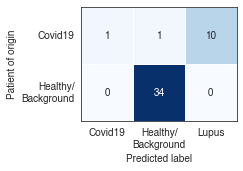


************************************************************

linearsvm_ovr.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.931 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.931 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.974 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.974 +/- 0.000 (in 1 folds)
Accuracy: 0.393 +/- 0.000 (in 1 folds)
MCC: 0.132 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.393
MCC: 0.132

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.31      0.82      0.45        17
Healthy/Background       1.00      0.21      0.34        39
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.39        56
         macro avg       0.44      0.34      0.26        56
      weighted avg       0.79      0.39      0.37        56



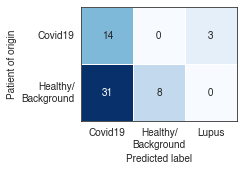


************************************************************

linearsvm_ovr.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.968 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.968 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.990 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.990 +/- 0.000 (in 1 folds)
Accuracy: 0.413 +/- 0.000 (in 1 folds)
MCC: 0.212 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.413
MCC: 0.212

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.30      0.92      0.45        12
Healthy/Background       1.00      0.24      0.38        34
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.41        46
         macro avg       0.43      0.38      0.28        46
      weighted avg       0.82      0.41      0.40        46



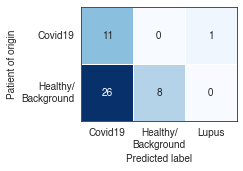


************************************************************

linearsvm_ovr.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.968 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.968 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.990 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.990 +/- 0.000 (in 1 folds)
Accuracy: 0.739 +/- 0.000 (in 1 folds)
MCC: 0.500 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.739
MCC: 0.500

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00        12
Healthy/Background       1.00      1.00      1.00        34
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.74        46
         macro avg       0.33      0.33      0.33        46
      weighted avg       0.74      0.74      0.74        46



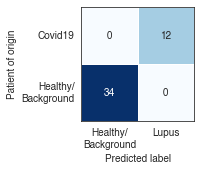


************************************************************

rf_multiclass.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.995 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.995 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.998 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.998 +/- 0.000 (in 1 folds)
Accuracy: 0.857 +/- 0.000 (in 1 folds)
MCC: 0.705 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.857
MCC: 0.705

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.91      0.59      0.71        17
Healthy/Background       0.97      0.97      0.97        39
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.86        56
         macro avg       0.63      0.52      0.56        56
      weighted avg       0.95      0.86      0.90        56



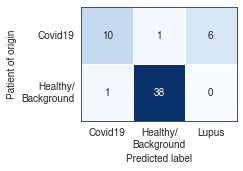


************************************************************

rf_multiclass.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 0.913 +/- 0.000 (in 1 folds)
MCC: 0.802 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.913
MCC: 0.802

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.67      0.80        12
Healthy/Background       1.00      1.00      1.00        34
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.91        46
         macro avg       0.67      0.56      0.60        46
      weighted avg       1.00      0.91      0.95        46



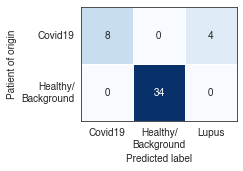


************************************************************

rf_multiclass.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 0.891 +/- 0.000 (in 1 folds)
MCC: 0.716 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.891
MCC: 0.716

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.58      0.74        12
Healthy/Background       0.89      1.00      0.94        34
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.89        46
         macro avg       0.63      0.53      0.56        46
      weighted avg       0.92      0.89      0.89        46



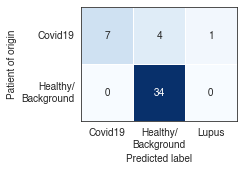


************************************************************



## GeneLocus.BCR|TCR

2023-01-05 10:18:20,061 - evaluate_external_cohorts.ipynb - WARNING - No external cohort specimens found for GeneLocus.BCR|TCR


### (<GeneLocus.BCR: 1>, 'lasso_cv.untuned.all_data')

,BCR:repertoire_stats:Covid19,BCR:repertoire_stats:HIV,BCR:repertoire_stats:Healthy/Background,BCR:repertoire_stats:Lupus,BCR:convergent_cluster_model:Covid19,BCR:convergent_cluster_model:HIV,BCR:convergent_cluster_model:Healthy/Background,BCR:convergent_cluster_model:Lupus,BCR:sequence_model:Covid19,BCR:sequence_model:HIV,BCR:sequence_model:Healthy/Background,BCR:sequence_model:Lupus
specimen_label,,,,,,,,,,,,
326650_1,0.000468,0.002876,3.785261e-01,0.618130,1.177030e-16,5.976970e-10,0.993367,0.006633,0.258446,0.215543,0.266239,0.259772
326737_1,0.000073,0.047494,9.397890e-01,0.012644,5.743506e-07,9.474364e-01,0.000286,0.052277,0.228463,0.282711,0.232986,0.255840
326780_1,0.002458,0.132180,6.220465e-01,0.243316,8.233800e-12,1.625703e-04,0.967116,0.032722,0.207107,0.259720,0.302954,0.230219
326797_1,0.203272,0.047158,5.095251e-01,0.240045,1.632033e-14,7.837999e-10,0.999997,0.000003,0.256668,0.217747,0.270678,0.254907
327059_1,0.005250,0.025931,8.644624e-01,0.104357,9.144548e-17,1.057598e-01,0.868423,0.025817,0.232894,0.256681,0.272384,0.238042
D103_1,0.004960,0.001024,1.567102e-01,0.837306,1.536693e-08,8.106917e-07,0.999991,0.000008,0.257168,0.219825,0.275940,0.247067
5f21e814e1adeb2edc12613d,0.997781,0.002069,4.984411e-07,0.000150,9.877566e-01,6.758902e-05,0.012103,0.000072,0.246630,0.235526,0.283026,0.234817
5f21e815e1adeb2edc126140,0.989055,0.002438,1.954238e-03,0.006553,6.526931e-01,1.285051e-04,0.345807,0.001371,0.215265,0.260308,0.301000,0.223426
5f21e816e1adeb2edc126142,0.993744,0.002574,1.958600e-03,0.001723,9.989734e-01,2.695833e-04,0.000610,0.000147,0.235809,0.235741,0.300082,0.228368


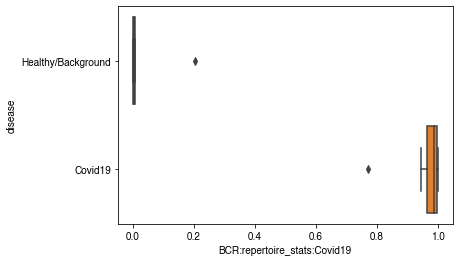

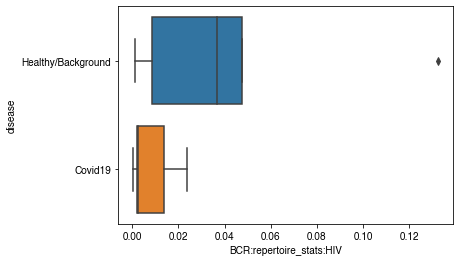

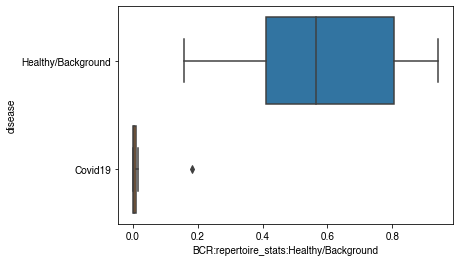

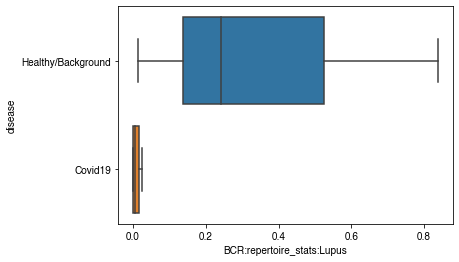

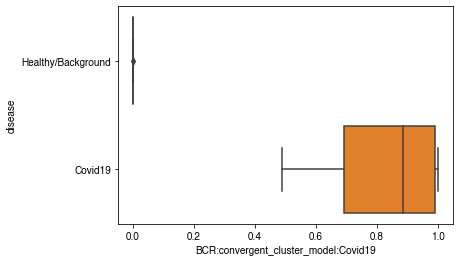

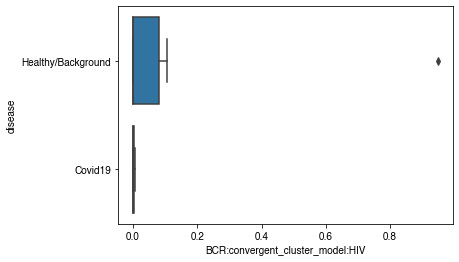

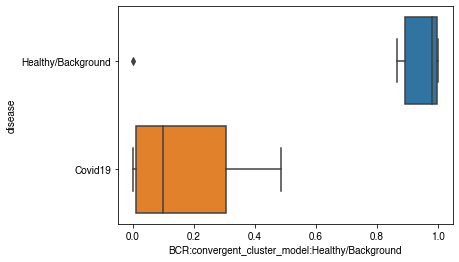

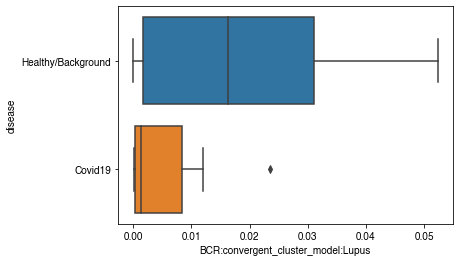

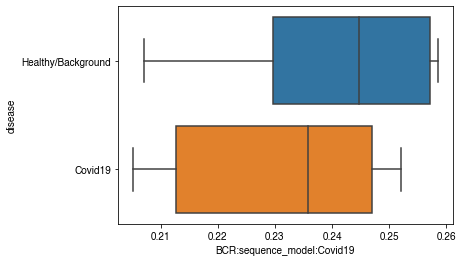

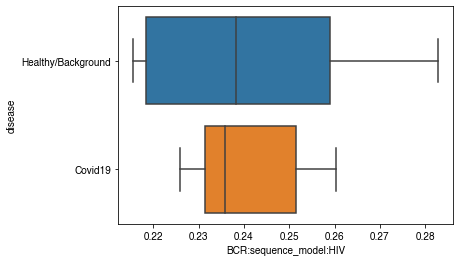

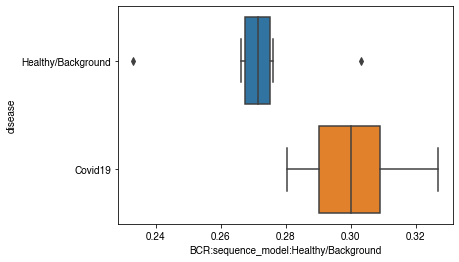

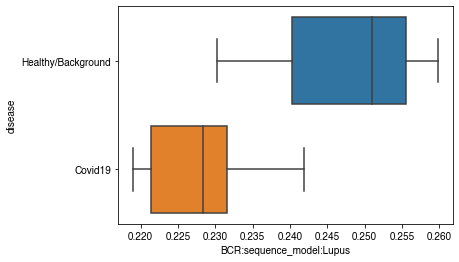

---

### (<GeneLocus.TCR: 2>, 'lasso_cv.untuned.all_data')

,TCR:repertoire_stats:Covid19,TCR:repertoire_stats:HIV,TCR:repertoire_stats:Healthy/Background,TCR:repertoire_stats:Lupus,TCR:convergent_cluster_model:Covid19,TCR:convergent_cluster_model:HIV,TCR:convergent_cluster_model:Healthy/Background,TCR:convergent_cluster_model:Lupus,TCR:sequence_model:Covid19,TCR:sequence_model:HIV,TCR:sequence_model:Healthy/Background,TCR:sequence_model:Lupus
specimen_label,,,,,,,,,,,,
A3-i101,0.073017,0.043314,0.870289,0.013380,1.497689e-12,3.766311e-06,0.997109,0.002887,0.257354,0.219413,0.260308,0.262925
6047f702136a6d924982945c,0.164042,0.005219,0.044708,0.786031,2.203342e-03,3.244018e-03,0.168600,0.825953,0.256690,0.223439,0.253769,0.266102
5f07aa8839579433171763b4,0.795861,0.007999,0.173702,0.022437,4.084824e-03,1.108249e-03,0.735181,0.259626,0.257682,0.221571,0.259923,0.260824
5f07aa8939579433171763b7,0.437254,0.012868,0.066851,0.483027,3.096047e-02,9.493562e-05,0.106506,0.862438,0.257845,0.225682,0.256659,0.259813
6047f703136a6d924982945f,0.991324,0.000868,0.003250,0.004558,1.881247e-01,1.404089e-03,0.047383,0.763088,0.258106,0.218315,0.254300,0.269279
6047f704136a6d9249829462,0.767954,0.001690,0.027639,0.202717,1.969538e-01,1.051475e-03,0.354424,0.447571,0.256264,0.224160,0.258945,0.260630
6047f704136a6d9249829465,0.935776,0.001376,0.003424,0.059424,1.319276e-03,1.133196e-04,0.374008,0.624560,0.259440,0.224510,0.256714,0.259336
5f07aa8a39579433171763ba,0.732501,0.042478,0.134093,0.090928,7.831033e-05,4.287017e-04,0.378936,0.620557,0.257170,0.226214,0.258033,0.258583
6047f706136a6d924982946b,0.915788,0.004359,0.047321,0.032532,6.713170e-07,2.600678e-05,0.325961,0.674012,0.256733,0.217872,0.262417,0.262979


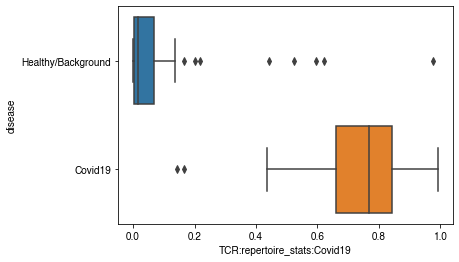

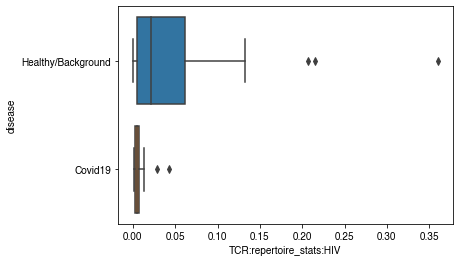

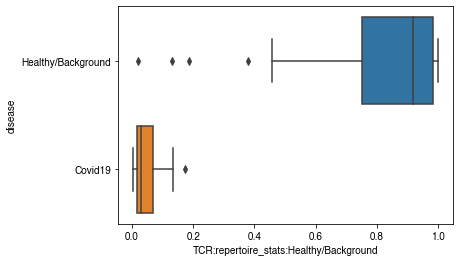

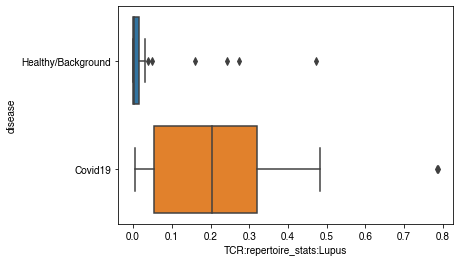

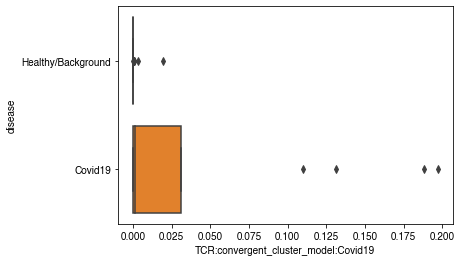

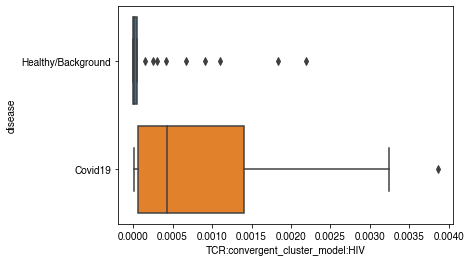

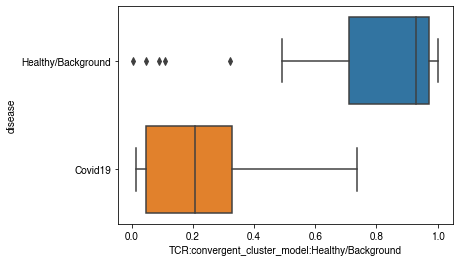

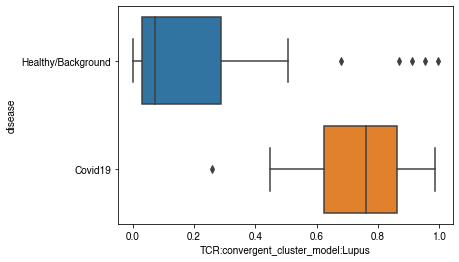

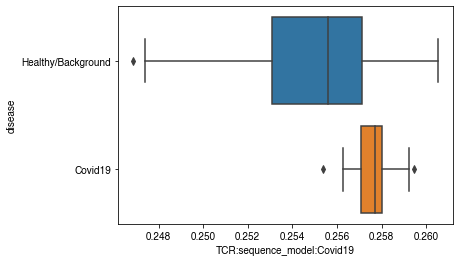

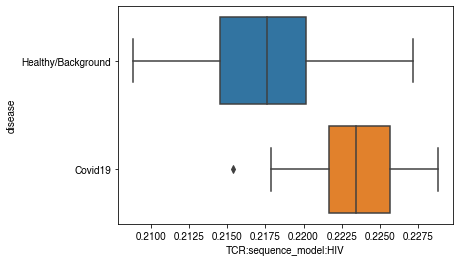

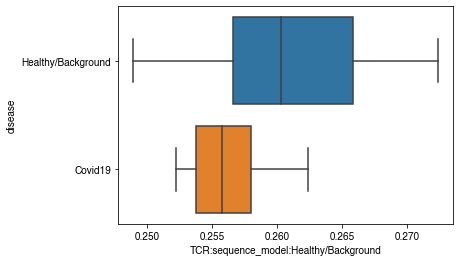

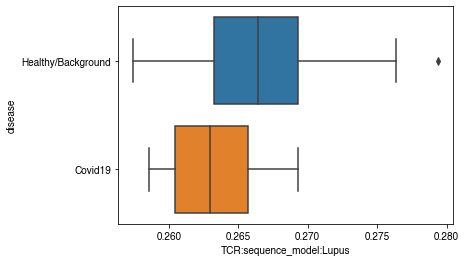

---

In [8]:
featurized_by_gene_locus_and_model_name = kdict()
results_by_gene_locus = {}

for gene_locus in gene_loci:
    # run on single locus
    results, featurized_by_metamodel_name = run(
        gene_locus=gene_locus,
        different_platform=False,
        classification_target=evaluation_target,
        output_dir=config.paths.external_cohort_evaluation_output_dir
        / "default"
        / gene_locus.name,
    )
    if results is not None:
        results_by_gene_locus[gene_locus] = results
        for metamodel_name, featurized in featurized_by_metamodel_name.items():
            featurized_by_gene_locus_and_model_name[
                gene_locus, metamodel_name
            ] = featurized

if len(gene_loci) > 1:
    # run on multiple loci
    results, featurized_by_metamodel_name = run(
        gene_locus=gene_loci,
        different_platform=False,
        classification_target=evaluation_target,
        output_dir=config.paths.external_cohort_evaluation_output_dir
        / "default"
        / gene_loci.name,
    )
    if results is not None:
        results_by_gene_locus[gene_loci] = results
        for metamodel_name, featurized in featurized_by_metamodel_name.items():
            featurized_by_gene_locus_and_model_name[
                gene_loci, metamodel_name
            ] = featurized


# Visualize subcomponent predictions
# (Have to use this awkward kdict notation because GeneLocus flag-enum key is not well handled)
any_metamodel_name = featurized_by_gene_locus_and_model_name.keys(dimensions=1)[0]
for key, featurized in featurized_by_gene_locus_and_model_name[
    :, any_metamodel_name
].items():
    gene_locus, _ = key
    output_dir = (
        config.paths.high_res_outputs_dir
        / "external_cohort_evaluation"
        / "default"
        / gene_locus.name
    )
    output_dir.mkdir(parents=True, exist_ok=True)

    display(Markdown(f"### {key}"))
    display(featurized.X)

    for col in featurized.X.columns:
        fig = plt.figure()
        sns.boxplot(
            data=pd.concat([featurized.X[col], featurized.metadata], axis=1),
            x=col,
            y="disease",
        )
        genetools.plots.savefig(
            fig, output_dir / f"subcomponent.{slugify(col)}.png", dpi=300
        )
        display(fig)
        plt.close(fig)
    display(Markdown("---"))

## External cohorts similar to our sequencing process: Demographics-only metamodel for comparison

## GeneLocus.BCR

2023-01-05 10:18:24,147 - evaluate_external_cohorts.ipynb - WARNING - Skipping these missing specimens for GeneLocus.BCR: ['5578047616589173226-242ac116-0001-012'
 '5594669140024693226-242ac116-0001-012'
 '5549400184724853226-242ac116-0001-012'
 '5563272929090933226-242ac116-0001-012'
 '6199958881049973226-242ac116-0001-012'
 '6219758680284533226-242ac116-0001-012'
 '6162506766228853226-242ac116-0001-012'
 '6180202031488373226-242ac116-0001-012'
 '6272329079987573226-242ac116-0001-012'
 '6286545421737333226-242ac116-0001-012'
 '6235177612877173226-242ac116-0001-012'
 '6255707556552053226-242ac116-0001-012'
 '6333961860685173226-242ac116-0001-012'
 '6347448057994613226-242ac116-0001-012'
 '6301749605965173226-242ac116-0001-012'
 '6318371129400693226-242ac116-0001-012'
 '6392545214602613226-242ac116-0001-012'
 '6410541127572853226-242ac116-0001-012'
 '6361063104322933226-242ac116-0001-012'
 '6374978798361973226-242ac116-0001-012'
 '6458344113577333226-242ac116-0001-012'
 '647256045532709

,ROC-AUC (weighted OvO) per fold,ROC-AUC (macro OvO) per fold,au-PRC (weighted OvO) per fold,au-PRC (macro OvO) per fold,Accuracy per fold,MCC per fold,Accuracy global,MCC global,sample_size,n_abstentions,sample_size including abstentions,abstention_rate,missing_classes
elasticnet_cv.untuned.test_subset,0.867 +/- 0.000 (in 1 folds),0.867 +/- 0.000 (in 1 folds),0.867 +/- 0.000 (in 1 folds),0.867 +/- 0.000 (in 1 folds),0.375 +/- 0.000 (in 1 folds),0.000 +/- 0.000 (in 1 folds),0.375,0.000,8,0,8,0.0,True
elasticnet_cv.tuned.test_subset,0.867 +/- 0.000 (in 1 folds),0.867 +/- 0.000 (in 1 folds),0.867 +/- 0.000 (in 1 folds),0.867 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000 +/- 0.000 (in 1 folds),1.000,1.000,8,0,8,0.0,False
elasticnet_cv.untuned.all_data,0.771 +/- 0.000 (in 1 folds),0.771 +/- 0.000 (in 1 folds),0.811 +/- 0.000 (in 1 folds),0.811 +/- 0.000 (in 1 folds),0.417 +/- 0.000 (in 1 folds),0.000 +/- 0.000 (in 1 folds),0.417,0.000,12,0,12,0.0,True
lasso_multiclass.untuned.test_subset,0.533 +/- 0.000 (in 1 folds),0.533 +/- 0.000 (in 1 folds),0.514 +/- 0.000 (in 1 folds),0.514 +/- 0.000 (in 1 folds),0.250 +/- 0.000 (in 1 folds),0.129 +/- 0.000 (in 1 folds),0.250,0.129,8,0,8,0.0,False
lasso_multiclass.tuned.test_subset,0.533 +/- 0.000 (in 1 folds),0.533 +/- 0.000 (in 1 folds),0.514 +/- 0.000 (in 1 folds),0.514 +/- 0.000 (in 1 folds),0.625 +/- 0.000 (in 1 folds),0.447 +/- 0.000 (in 1 folds),0.625,0.447,8,0,8,0.0,False
rf_multiclass.untuned.test_subset,0.533 +/- 0.000 (in 1 folds),0.533 +/- 0.000 (in 1 folds),0.443 +/- 0.000 (in 1 folds),0.443 +/- 0.000 (in 1 folds),0.375 +/- 0.000 (in 1 folds),0.000 +/- 0.000 (in 1 folds),0.375,0.000,8,0,8,0.0,True
linearsvm_ovr.tuned.test_subset,0.533 +/- 0.000 (in 1 folds),0.533 +/- 0.000 (in 1 folds),0.514 +/- 0.000 (in 1 folds),0.514 +/- 0.000 (in 1 folds),0.750 +/- 0.000 (in 1 folds),0.467 +/- 0.000 (in 1 folds),0.750,0.467,8,0,8,0.0,False
linearsvm_ovr.untuned.test_subset,0.533 +/- 0.000 (in 1 folds),0.533 +/- 0.000 (in 1 folds),0.514 +/- 0.000 (in 1 folds),0.514 +/- 0.000 (in 1 folds),0.250 +/- 0.000 (in 1 folds),-0.244 +/- 0.000 (in 1 folds),0.250,-0.244,8,0,8,0.0,False
xgboost.tuned.test_subset,0.533 +/- 0.000 (in 1 folds),0.533 +/- 0.000 (in 1 folds),0.514 +/- 0.000 (in 1 folds),0.514 +/- 0.000 (in 1 folds),0.250 +/- 0.000 (in 1 folds),-0.244 +/- 0.000 (in 1 folds),0.250,-0.244,8,0,8,0.0,False
xgboost.untuned.test_subset,0.533 +/- 0.000 (in 1 folds),0.533 +/- 0.000 (in 1 folds),0.514 +/- 0.000 (in 1 folds),0.514 +/- 0.000 (in 1 folds),0.250 +/- 0.000 (in 1 folds),-0.244 +/- 0.000 (in 1 folds),0.250,-0.244,8,0,8,0.0,False


lasso_cv.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.343 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.343 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.416 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.416 +/- 0.000 (in 1 folds)
Accuracy: 0.417 +/- 0.000 (in 1 folds)
MCC: 0.000 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.417
MCC: 0.000

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00         7
Healthy/Background       0.42      1.00      0.59         5

          accuracy                           0.42        12
         macro avg       0.21      0.50      0.29        12
      weighted avg       0.17      0.42      0.25        12



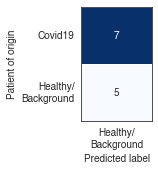


************************************************************

lasso_cv.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.533 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.533 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.514 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.514 +/- 0.000 (in 1 folds)
Accuracy: 0.375 +/- 0.000 (in 1 folds)
MCC: 0.000 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.375
MCC: 0.000

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00         5
Healthy/Background       0.38      1.00      0.55         3

          accuracy                           0.38         8
         macro avg       0.19      0.50      0.27         8
      weighted avg       0.14      0.38      0.20         8



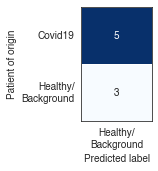


************************************************************

lasso_cv.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.533 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.533 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.514 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.514 +/- 0.000 (in 1 folds)
Accuracy: 0.750 +/- 0.000 (in 1 folds)
MCC: 0.600 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.750
MCC: 0.600

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.60      0.75         5
Healthy/Background       0.60      1.00      0.75         3

          accuracy                           0.75         8
         macro avg       0.80      0.80      0.75         8
      weighted avg       0.85      0.75      0.75         8



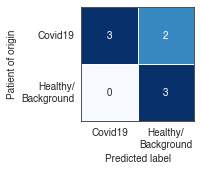


************************************************************

ridge_cv.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.343 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.343 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.416 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.416 +/- 0.000 (in 1 folds)
Accuracy: 0.417 +/- 0.000 (in 1 folds)
MCC: 0.000 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.417
MCC: 0.000

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00         7
Healthy/Background       0.42      1.00      0.59         5

          accuracy                           0.42        12
         macro avg       0.21      0.50      0.29        12
      weighted avg       0.17      0.42      0.25        12



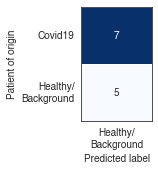


************************************************************

ridge_cv.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.533 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.533 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.514 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.514 +/- 0.000 (in 1 folds)
Accuracy: 0.375 +/- 0.000 (in 1 folds)
MCC: 0.000 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.375
MCC: 0.000

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00         5
Healthy/Background       0.38      1.00      0.55         3

          accuracy                           0.38         8
         macro avg       0.19      0.50      0.27         8
      weighted avg       0.14      0.38      0.20         8



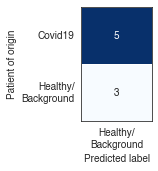


************************************************************

ridge_cv.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.533 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.533 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.514 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.514 +/- 0.000 (in 1 folds)
Accuracy: 0.625 +/- 0.000 (in 1 folds)
MCC: 0.447 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.625
MCC: 0.447

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.40      0.57         5
Healthy/Background       0.50      1.00      0.67         3

          accuracy                           0.62         8
         macro avg       0.75      0.70      0.62         8
      weighted avg       0.81      0.62      0.61         8



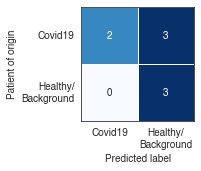


************************************************************

elasticnet_cv.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.771 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.771 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.811 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.811 +/- 0.000 (in 1 folds)
Accuracy: 0.417 +/- 0.000 (in 1 folds)
MCC: 0.000 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.417
MCC: 0.000

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00         7
Healthy/Background       0.42      1.00      0.59         5

          accuracy                           0.42        12
         macro avg       0.21      0.50      0.29        12
      weighted avg       0.17      0.42      0.25        12



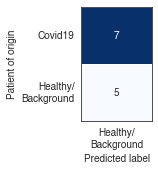


************************************************************

elasticnet_cv.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.867 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.867 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.867 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.867 +/- 0.000 (in 1 folds)
Accuracy: 0.375 +/- 0.000 (in 1 folds)
MCC: 0.000 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.375
MCC: 0.000

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00         5
Healthy/Background       0.38      1.00      0.55         3

          accuracy                           0.38         8
         macro avg       0.19      0.50      0.27         8
      weighted avg       0.14      0.38      0.20         8



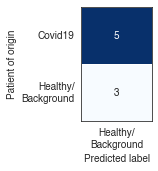


************************************************************

elasticnet_cv.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.867 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.867 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.867 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.867 +/- 0.000 (in 1 folds)
Accuracy: 1.000 +/- 0.000 (in 1 folds)
MCC: 1.000 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 1.000
MCC: 1.000

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      1.00      1.00         5
Healthy/Background       1.00      1.00      1.00         3

          accuracy                           1.00         8
         macro avg       1.00      1.00      1.00         8
      weighted avg       1.00      1.00      1.00         8



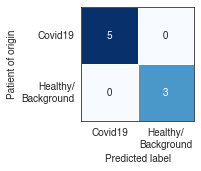


************************************************************

lasso_multiclass.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.343 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.343 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.416 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.416 +/- 0.000 (in 1 folds)
Accuracy: 0.250 +/- 0.000 (in 1 folds)
MCC: 0.014 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.250
MCC: 0.014

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00         7
Healthy/Background       0.43      0.60      0.50         5
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.25        12
         macro avg       0.14      0.20      0.17        12
      weighted avg       0.18      0.25      0.21        12



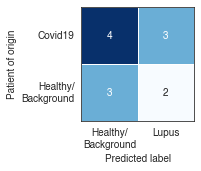


************************************************************

lasso_multiclass.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.533 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.533 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.514 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.514 +/- 0.000 (in 1 folds)
Accuracy: 0.250 +/- 0.000 (in 1 folds)
MCC: 0.129 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.250
MCC: 0.129

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00         5
Healthy/Background       0.50      0.67      0.57         3
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.25         8
         macro avg       0.17      0.22      0.19         8
      weighted avg       0.19      0.25      0.21         8



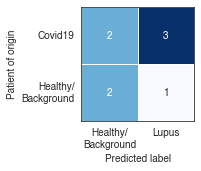


************************************************************

lasso_multiclass.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.533 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.533 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.514 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.514 +/- 0.000 (in 1 folds)
Accuracy: 0.625 +/- 0.000 (in 1 folds)
MCC: 0.447 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.625
MCC: 0.447

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.40      0.57         5
Healthy/Background       0.50      1.00      0.67         3

          accuracy                           0.62         8
         macro avg       0.75      0.70      0.62         8
      weighted avg       0.81      0.62      0.61         8



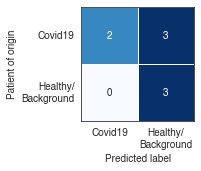


************************************************************

xgboost.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.400 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.400 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.456 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.456 +/- 0.000 (in 1 folds)
Accuracy: 0.333 +/- 0.000 (in 1 folds)
MCC: -0.178 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.333
MCC: -0.178

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00         7
Healthy/Background       0.36      0.80      0.50         5
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.33        12
         macro avg       0.12      0.27      0.17        12
      weighted avg       0.15      0.33      0.21        12



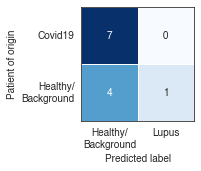


************************************************************

xgboost.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.533 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.533 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.514 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.514 +/- 0.000 (in 1 folds)
Accuracy: 0.250 +/- 0.000 (in 1 folds)
MCC: -0.244 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.250
MCC: -0.244

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00         5
Healthy/Background       0.29      0.67      0.40         3
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.25         8
         macro avg       0.10      0.22      0.13         8
      weighted avg       0.11      0.25      0.15         8



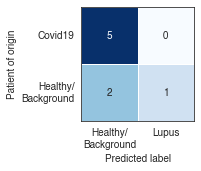


************************************************************

xgboost.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.533 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.533 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.514 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.514 +/- 0.000 (in 1 folds)
Accuracy: 0.250 +/- 0.000 (in 1 folds)
MCC: -0.244 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.250
MCC: -0.244

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00         5
Healthy/Background       0.29      0.67      0.40         3
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.25         8
         macro avg       0.10      0.22      0.13         8
      weighted avg       0.11      0.25      0.15         8



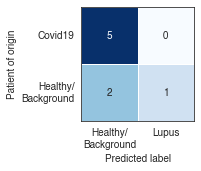


************************************************************

linearsvm_ovr.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.343 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.343 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.416 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.416 +/- 0.000 (in 1 folds)
Accuracy: 0.250 +/- 0.000 (in 1 folds)
MCC: -0.265 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.250
MCC: -0.265

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00         7
Healthy/Background       0.30      0.60      0.40         5
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.25        12
         macro avg       0.10      0.20      0.13        12
      weighted avg       0.12      0.25      0.17        12



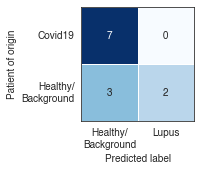


************************************************************

linearsvm_ovr.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.533 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.533 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.514 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.514 +/- 0.000 (in 1 folds)
Accuracy: 0.250 +/- 0.000 (in 1 folds)
MCC: -0.244 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.250
MCC: -0.244

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00         5
Healthy/Background       0.29      0.67      0.40         3
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.25         8
         macro avg       0.10      0.22      0.13         8
      weighted avg       0.11      0.25      0.15         8



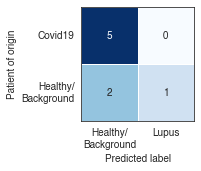


************************************************************

linearsvm_ovr.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.533 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.533 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.514 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.514 +/- 0.000 (in 1 folds)
Accuracy: 0.750 +/- 0.000 (in 1 folds)
MCC: 0.467 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.750
MCC: 0.467

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.80      0.80      0.80         5
Healthy/Background       0.67      0.67      0.67         3

          accuracy                           0.75         8
         macro avg       0.73      0.73      0.73         8
      weighted avg       0.75      0.75      0.75         8



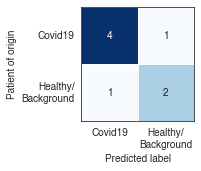


************************************************************

rf_multiclass.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.386 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.386 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.421 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.421 +/- 0.000 (in 1 folds)
Accuracy: 0.417 +/- 0.000 (in 1 folds)
MCC: 0.000 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.417
MCC: 0.000

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00         7
Healthy/Background       0.42      1.00      0.59         5

          accuracy                           0.42        12
         macro avg       0.21      0.50      0.29        12
      weighted avg       0.17      0.42      0.25        12



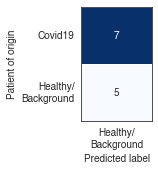


************************************************************

rf_multiclass.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.533 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.533 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.443 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.443 +/- 0.000 (in 1 folds)
Accuracy: 0.375 +/- 0.000 (in 1 folds)
MCC: 0.000 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.375
MCC: 0.000

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00         5
Healthy/Background       0.38      1.00      0.55         3

          accuracy                           0.38         8
         macro avg       0.19      0.50      0.27         8
      weighted avg       0.14      0.38      0.20         8



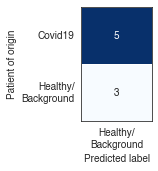


************************************************************

rf_multiclass.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.533 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.533 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.443 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.443 +/- 0.000 (in 1 folds)
Accuracy: 0.375 +/- 0.000 (in 1 folds)
MCC: 0.000 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.375
MCC: 0.000

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00         5
Healthy/Background       0.38      1.00      0.55         3

          accuracy                           0.38         8
         macro avg       0.19      0.50      0.27         8
      weighted avg       0.14      0.38      0.20         8



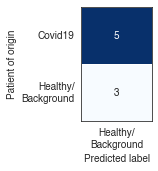


************************************************************



## GeneLocus.TCR

2023-01-05 10:21:56,814 - evaluate_external_cohorts.ipynb - WARNING - Skipping these missing specimens for GeneLocus.TCR: ['P00311' 'P00104' 'P00511' 'Keck0013_MC1' 'P00599' 'P00130'
 'Keck0099_MC1' 'P00415' 'P00583' 'P00534' 'P00407' 'P00513'
 'Keck0081_MC1' 'P00644' 'P00174' 'P00432' 'P00381' 'Keck0082_MC1'
 'P00167' 'P00554' 'P00606' 'P00368' 'P00203' 'Keck0007_MC1' 'P00414'
 'Keck0036_MC1' 'P00530' 'P00030' 'Keck0088_MC1' 'P00334' 'P00587'
 'P00395' 'Keck0015_MC1' 'P00056' 'P00095' 'P00156' 'P00032' 'P00520'
 'P00387' 'P00299' 'P00384' 'P00548' 'P00422' 'P00198' 'P00085' 'P00596'
 'P00400' 'P00039' 'P00128' 'P00589' 'P00592' 'P00172' 'P00161' 'P00102'
 'P00425' 'P00537' 'P00458' 'P00624' 'Keck0011_MC1' 'P00551' 'P00569'
 'P00036' 'Keck0083_MC1' 'P00642' 'P00107' 'P00223' 'P00159' 'P00047'
 'Keck0070_MC1' 'Keck0074_MC1' 'P00046' 'P00126' 'P00631' 'P00597'
 'P00616' 'P00471' 'P00224' 'P00075' 'P00539' 'Keck0040_MC1' 'P00433'
 'Keck0017_MC1' 'P00178' 'P00037' 'Keck0003_MC1' 'P00197' '

,ROC-AUC (weighted OvO) per fold,ROC-AUC (macro OvO) per fold,au-PRC (weighted OvO) per fold,au-PRC (macro OvO) per fold,Accuracy per fold,MCC per fold,Accuracy global,MCC global,sample_size,n_abstentions,sample_size including abstentions,abstention_rate,missing_classes
lasso_cv.tuned.test_subset,0.725 +/- 0.000 (in 1 folds),0.725 +/- 0.000 (in 1 folds),0.895 +/- 0.000 (in 1 folds),0.895 +/- 0.000 (in 1 folds),0.239 +/- 0.000 (in 1 folds),0.167 +/- 0.000 (in 1 folds),0.239,0.167,46,0,46,0.0,False
lasso_cv.untuned.test_subset,0.725 +/- 0.000 (in 1 folds),0.725 +/- 0.000 (in 1 folds),0.895 +/- 0.000 (in 1 folds),0.895 +/- 0.000 (in 1 folds),0.739 +/- 0.000 (in 1 folds),0.000 +/- 0.000 (in 1 folds),0.739,0.000,46,0,46,0.0,True
elasticnet_cv.untuned.test_subset,0.708 +/- 0.000 (in 1 folds),0.708 +/- 0.000 (in 1 folds),0.887 +/- 0.000 (in 1 folds),0.887 +/- 0.000 (in 1 folds),0.739 +/- 0.000 (in 1 folds),0.000 +/- 0.000 (in 1 folds),0.739,0.000,46,0,46,0.0,True
elasticnet_cv.tuned.test_subset,0.708 +/- 0.000 (in 1 folds),0.708 +/- 0.000 (in 1 folds),0.887 +/- 0.000 (in 1 folds),0.887 +/- 0.000 (in 1 folds),0.174 +/- 0.000 (in 1 folds),0.136 +/- 0.000 (in 1 folds),0.174,0.136,46,0,46,0.0,False
ridge_cv.untuned.test_subset,0.696 +/- 0.000 (in 1 folds),0.696 +/- 0.000 (in 1 folds),0.882 +/- 0.000 (in 1 folds),0.882 +/- 0.000 (in 1 folds),0.739 +/- 0.000 (in 1 folds),0.000 +/- 0.000 (in 1 folds),0.739,0.000,46,0,46,0.0,True
ridge_cv.tuned.test_subset,0.696 +/- 0.000 (in 1 folds),0.696 +/- 0.000 (in 1 folds),0.882 +/- 0.000 (in 1 folds),0.882 +/- 0.000 (in 1 folds),0.283 +/- 0.000 (in 1 folds),0.143 +/- 0.000 (in 1 folds),0.283,0.143,46,0,46,0.0,False
lasso_cv.untuned.all_data,0.683 +/- 0.000 (in 1 folds),0.683 +/- 0.000 (in 1 folds),0.856 +/- 0.000 (in 1 folds),0.856 +/- 0.000 (in 1 folds),0.696 +/- 0.000 (in 1 folds),0.000 +/- 0.000 (in 1 folds),0.696,0.000,56,0,56,0.0,True
elasticnet_cv.untuned.all_data,0.673 +/- 0.000 (in 1 folds),0.673 +/- 0.000 (in 1 folds),0.852 +/- 0.000 (in 1 folds),0.852 +/- 0.000 (in 1 folds),0.696 +/- 0.000 (in 1 folds),0.000 +/- 0.000 (in 1 folds),0.696,0.000,56,0,56,0.0,True
ridge_cv.untuned.all_data,0.661 +/- 0.000 (in 1 folds),0.661 +/- 0.000 (in 1 folds),0.848 +/- 0.000 (in 1 folds),0.848 +/- 0.000 (in 1 folds),0.696 +/- 0.000 (in 1 folds),0.000 +/- 0.000 (in 1 folds),0.696,0.000,56,0,56,0.0,True
linearsvm_ovr.untuned.test_subset,0.618 +/- 0.000 (in 1 folds),0.618 +/- 0.000 (in 1 folds),0.846 +/- 0.000 (in 1 folds),0.846 +/- 0.000 (in 1 folds),0.739 +/- 0.000 (in 1 folds),0.000 +/- 0.000 (in 1 folds),0.739,0.000,46,0,46,0.0,True


lasso_cv.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.683 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.683 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.856 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.856 +/- 0.000 (in 1 folds)
Accuracy: 0.696 +/- 0.000 (in 1 folds)
MCC: 0.000 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.696
MCC: 0.000

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00        17
Healthy/Background       0.70      1.00      0.82        39

          accuracy                           0.70        56
         macro avg       0.35      0.50      0.41        56
      weighted avg       0.49      0.70      0.57        56



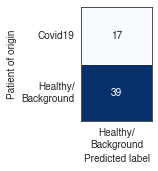


************************************************************

lasso_cv.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.725 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.725 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.895 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.895 +/- 0.000 (in 1 folds)
Accuracy: 0.739 +/- 0.000 (in 1 folds)
MCC: 0.000 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.739
MCC: 0.000

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00        12
Healthy/Background       0.74      1.00      0.85        34

          accuracy                           0.74        46
         macro avg       0.37      0.50      0.42        46
      weighted avg       0.55      0.74      0.63        46



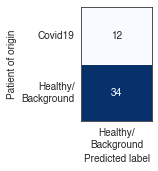


************************************************************

lasso_cv.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.725 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.725 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.895 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.895 +/- 0.000 (in 1 folds)
Accuracy: 0.239 +/- 0.000 (in 1 folds)
MCC: 0.167 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.239
MCC: 0.167

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00        12
Healthy/Background       1.00      0.32      0.49        34
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.24        46
         macro avg       0.33      0.11      0.16        46
      weighted avg       0.74      0.24      0.36        46



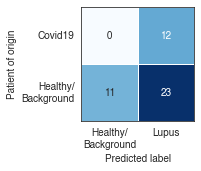


************************************************************

ridge_cv.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.661 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.661 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.848 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.848 +/- 0.000 (in 1 folds)
Accuracy: 0.696 +/- 0.000 (in 1 folds)
MCC: 0.000 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.696
MCC: 0.000

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00        17
Healthy/Background       0.70      1.00      0.82        39

          accuracy                           0.70        56
         macro avg       0.35      0.50      0.41        56
      weighted avg       0.49      0.70      0.57        56



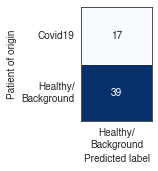


************************************************************

ridge_cv.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.696 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.696 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.882 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.882 +/- 0.000 (in 1 folds)
Accuracy: 0.739 +/- 0.000 (in 1 folds)
MCC: 0.000 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.739
MCC: 0.000

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00        12
Healthy/Background       0.74      1.00      0.85        34

          accuracy                           0.74        46
         macro avg       0.37      0.50      0.42        46
      weighted avg       0.55      0.74      0.63        46



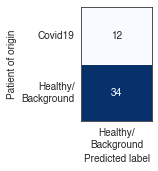


************************************************************

ridge_cv.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.696 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.696 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.882 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.882 +/- 0.000 (in 1 folds)
Accuracy: 0.283 +/- 0.000 (in 1 folds)
MCC: 0.143 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.283
MCC: 0.143

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00        12
Healthy/Background       0.93      0.38      0.54        34
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.28        46
         macro avg       0.31      0.13      0.18        46
      weighted avg       0.69      0.28      0.40        46



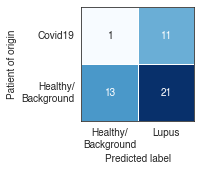


************************************************************

elasticnet_cv.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.673 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.673 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.852 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.852 +/- 0.000 (in 1 folds)
Accuracy: 0.696 +/- 0.000 (in 1 folds)
MCC: 0.000 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.696
MCC: 0.000

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00        17
Healthy/Background       0.70      1.00      0.82        39

          accuracy                           0.70        56
         macro avg       0.35      0.50      0.41        56
      weighted avg       0.49      0.70      0.57        56



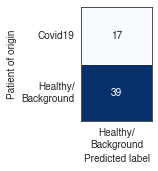


************************************************************

elasticnet_cv.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.708 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.708 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.887 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.887 +/- 0.000 (in 1 folds)
Accuracy: 0.739 +/- 0.000 (in 1 folds)
MCC: 0.000 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.739
MCC: 0.000

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00        12
Healthy/Background       0.74      1.00      0.85        34

          accuracy                           0.74        46
         macro avg       0.37      0.50      0.42        46
      weighted avg       0.55      0.74      0.63        46



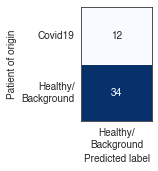


************************************************************

elasticnet_cv.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.708 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.708 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.887 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.887 +/- 0.000 (in 1 folds)
Accuracy: 0.174 +/- 0.000 (in 1 folds)
MCC: 0.136 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.174
MCC: 0.136

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00        12
Healthy/Background       1.00      0.24      0.38        34
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.17        46
         macro avg       0.33      0.08      0.13        46
      weighted avg       0.74      0.17      0.28        46



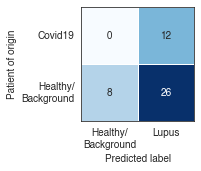


************************************************************

lasso_multiclass.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.463 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.463 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.720 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.720 +/- 0.000 (in 1 folds)
Accuracy: 0.589 +/- 0.000 (in 1 folds)
MCC: -0.073 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.589
MCC: -0.073

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00        17
Healthy/Background       0.69      0.85      0.76        39
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.59        56
         macro avg       0.23      0.28      0.25        56
      weighted avg       0.48      0.59      0.53        56



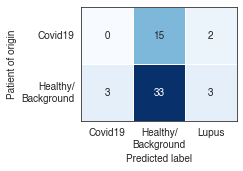


************************************************************

lasso_multiclass.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.578 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.578 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.811 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.811 +/- 0.000 (in 1 folds)
Accuracy: 0.674 +/- 0.000 (in 1 folds)
MCC: 0.055 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.674
MCC: 0.055

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00        12
Healthy/Background       0.76      0.91      0.83        34
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.67        46
         macro avg       0.25      0.30      0.28        46
      weighted avg       0.56      0.67      0.61        46



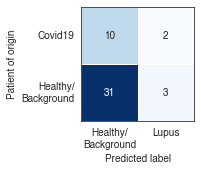


************************************************************

lasso_multiclass.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.578 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.578 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.811 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.811 +/- 0.000 (in 1 folds)
Accuracy: 0.652 +/- 0.000 (in 1 folds)
MCC: 0.032 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.652
MCC: 0.032

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00        12
Healthy/Background       0.75      0.88      0.81        34
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.65        46
         macro avg       0.25      0.29      0.27        46
      weighted avg       0.55      0.65      0.60        46



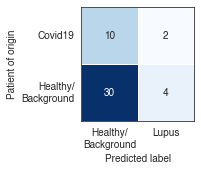


************************************************************

xgboost.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.417 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.417 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.694 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.694 +/- 0.000 (in 1 folds)
Accuracy: 0.571 +/- 0.000 (in 1 folds)
MCC: -0.144 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.571
MCC: -0.144

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00        17
Healthy/Background       0.67      0.82      0.74        39
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.57        56
         macro avg       0.22      0.27      0.25        56
      weighted avg       0.46      0.57      0.51        56



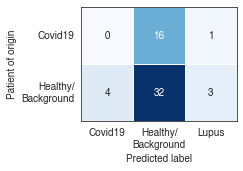


************************************************************

xgboost.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.430 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.430 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.736 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.736 +/- 0.000 (in 1 folds)
Accuracy: 0.674 +/- 0.000 (in 1 folds)
MCC: -0.004 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.674
MCC: -0.004

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00        12
Healthy/Background       0.74      0.91      0.82        34
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.67        46
         macro avg       0.25      0.30      0.27        46
      weighted avg       0.55      0.67      0.60        46



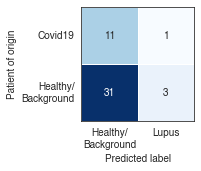


************************************************************

xgboost.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.430 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.430 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.736 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.736 +/- 0.000 (in 1 folds)
Accuracy: 0.674 +/- 0.000 (in 1 folds)
MCC: -0.004 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.674
MCC: -0.004

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00        12
Healthy/Background       0.74      0.91      0.82        34
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.67        46
         macro avg       0.25      0.30      0.27        46
      weighted avg       0.55      0.67      0.60        46



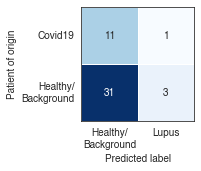


************************************************************

linearsvm_ovr.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.558 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.558 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.789 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.789 +/- 0.000 (in 1 folds)
Accuracy: 0.696 +/- 0.000 (in 1 folds)
MCC: 0.000 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.696
MCC: 0.000

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00        17
Healthy/Background       0.70      1.00      0.82        39

          accuracy                           0.70        56
         macro avg       0.35      0.50      0.41        56
      weighted avg       0.49      0.70      0.57        56



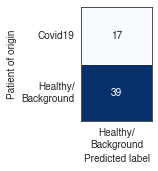


************************************************************

linearsvm_ovr.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.618 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.618 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.846 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.846 +/- 0.000 (in 1 folds)
Accuracy: 0.739 +/- 0.000 (in 1 folds)
MCC: 0.000 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.739
MCC: 0.000

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00        12
Healthy/Background       0.74      1.00      0.85        34

          accuracy                           0.74        46
         macro avg       0.37      0.50      0.42        46
      weighted avg       0.55      0.74      0.63        46



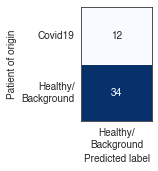


************************************************************

linearsvm_ovr.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.618 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.618 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.846 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.846 +/- 0.000 (in 1 folds)
Accuracy: 0.152 +/- 0.000 (in 1 folds)
MCC: 0.126 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.152
MCC: 0.126

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00        12
Healthy/Background       1.00      0.21      0.34        34
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.15        46
         macro avg       0.33      0.07      0.11        46
      weighted avg       0.74      0.15      0.25        46



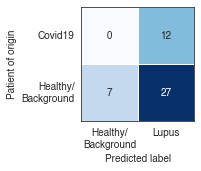


************************************************************

rf_multiclass.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.437 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.437 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.657 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.657 +/- 0.000 (in 1 folds)
Accuracy: 0.571 +/- 0.000 (in 1 folds)
MCC: -0.101 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.571
MCC: -0.101

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00        17
Healthy/Background       0.68      0.82      0.74        39
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.57        56
         macro avg       0.23      0.27      0.25        56
      weighted avg       0.47      0.57      0.52        56



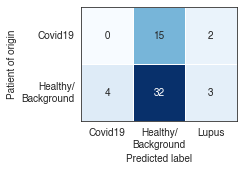


************************************************************

rf_multiclass.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.510 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.510 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.732 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.732 +/- 0.000 (in 1 folds)
Accuracy: 0.674 +/- 0.000 (in 1 folds)
MCC: 0.055 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.674
MCC: 0.055

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00        12
Healthy/Background       0.76      0.91      0.83        34
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.67        46
         macro avg       0.25      0.30      0.28        46
      weighted avg       0.56      0.67      0.61        46



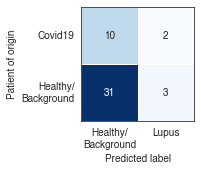


************************************************************

rf_multiclass.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.510 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.510 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.732 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.732 +/- 0.000 (in 1 folds)
Accuracy: 0.674 +/- 0.000 (in 1 folds)
MCC: 0.055 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.674
MCC: 0.055

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00        12
Healthy/Background       0.76      0.91      0.83        34
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.67        46
         macro avg       0.25      0.30      0.28        46
      weighted avg       0.56      0.67      0.61        46



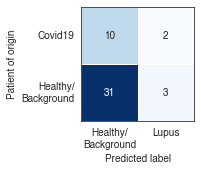


************************************************************



## GeneLocus.BCR|TCR

2023-01-05 10:47:46,663 - evaluate_external_cohorts.ipynb - WARNING - No external cohort specimens found for GeneLocus.BCR|TCR


In [9]:
for gene_locus in gene_loci:
    # run on single locus
    run(
        gene_locus=gene_locus,
        different_platform=False,
        classification_target=evaluation_target_with_demographics,
        output_dir=config.paths.external_cohort_evaluation_output_dir
        / "demographics_only"
        / gene_locus.name,
        metamodel_flavor="demographics_only",
    )

if len(gene_loci) > 1:
    # run on multiple loci
    run(
        gene_locus=gene_loci,
        different_platform=False,
        classification_target=evaluation_target_with_demographics,
        output_dir=config.paths.external_cohort_evaluation_output_dir
        / "demographics_only"
        / gene_loci.name,
        metamodel_flavor="demographics_only",
    )

# External cohorts different from our sequencing process

## GeneLocus.BCR

2023-01-05 10:47:46,742 - evaluate_external_cohorts.ipynb - WARNING - Skipping these missing specimens for GeneLocus.BCR: ['5578047616589173226-242ac116-0001-012'
 '5594669140024693226-242ac116-0001-012'
 '5549400184724853226-242ac116-0001-012'
 '5563272929090933226-242ac116-0001-012'
 '6199958881049973226-242ac116-0001-012'
 '6219758680284533226-242ac116-0001-012'
 '6162506766228853226-242ac116-0001-012'
 '6180202031488373226-242ac116-0001-012'
 '6272329079987573226-242ac116-0001-012'
 '6286545421737333226-242ac116-0001-012'
 '6235177612877173226-242ac116-0001-012'
 '6255707556552053226-242ac116-0001-012'
 '6333961860685173226-242ac116-0001-012'
 '6347448057994613226-242ac116-0001-012'
 '6301749605965173226-242ac116-0001-012'
 '6318371129400693226-242ac116-0001-012'
 '6392545214602613226-242ac116-0001-012'
 '6410541127572853226-242ac116-0001-012'
 '6361063104322933226-242ac116-0001-012'
 '6374978798361973226-242ac116-0001-012'
 '6458344113577333226-242ac116-0001-012'
 '647256045532709

## GeneLocus.TCR

2023-01-05 10:47:46,846 - evaluate_external_cohorts.ipynb - WARNING - Skipping these missing specimens for GeneLocus.TCR: ['P00311' 'P00104' 'P00511' 'Keck0013_MC1' 'P00599' 'P00130'
 'Keck0099_MC1' 'P00415' 'P00583' 'P00534' 'P00407' 'P00513'
 'Keck0081_MC1' 'P00644' 'P00174' 'P00432' 'P00381' 'Keck0082_MC1'
 'P00167' 'P00554' 'P00606' 'P00368' 'P00203' 'Keck0007_MC1' 'P00414'
 'Keck0036_MC1' 'P00530' 'P00030' 'Keck0088_MC1' 'P00334' 'P00587'
 'P00395' 'Keck0015_MC1' 'P00056' 'P00095' 'P00156' 'P00032' 'P00520'
 'P00387' 'P00299' 'P00384' 'P00548' 'P00422' 'P00198' 'P00085' 'P00596'
 'P00400' 'P00039' 'P00128' 'P00589' 'P00592' 'P00172' 'P00161' 'P00102'
 'P00425' 'P00537' 'P00458' 'P00624' 'Keck0011_MC1' 'P00551' 'P00569'
 'P00036' 'Keck0083_MC1' 'P00642' 'P00107' 'P00223' 'P00159' 'P00047'
 'Keck0070_MC1' 'Keck0074_MC1' 'P00046' 'P00126' 'P00631' 'P00597'
 'P00616' 'P00471' 'P00224' 'P00075' 'P00539' 'Keck0040_MC1' 'P00433'
 'Keck0017_MC1' 'P00178' 'P00037' 'Keck0003_MC1' 'P00197' '

,ROC-AUC (weighted OvO) per fold,ROC-AUC (macro OvO) per fold,au-PRC (weighted OvO) per fold,au-PRC (macro OvO) per fold,Accuracy per fold,MCC per fold,Accuracy global,MCC global,sample_size,n_abstentions,sample_size including abstentions,abstention_rate,missing_classes
linearsvm_ovr.untuned.all_data,0.786 +/- 0.000 (in 1 folds),0.786 +/- 0.000 (in 1 folds),0.765 +/- 0.000 (in 1 folds),0.765 +/- 0.000 (in 1 folds),0.452 +/- 0.000 (in 1 folds),0.227 +/- 0.000 (in 1 folds),0.452,0.227,186,0,186,0.0,False
lasso_cv.tuned.test_subset,0.780 +/- 0.000 (in 1 folds),0.780 +/- 0.000 (in 1 folds),0.783 +/- 0.000 (in 1 folds),0.783 +/- 0.000 (in 1 folds),0.687 +/- 0.000 (in 1 folds),0.388 +/- 0.000 (in 1 folds),0.687,0.388,166,0,166,0.0,False
linearsvm_ovr.tuned.test_subset,0.780 +/- 0.000 (in 1 folds),0.780 +/- 0.000 (in 1 folds),0.761 +/- 0.000 (in 1 folds),0.761 +/- 0.000 (in 1 folds),0.380 +/- 0.000 (in 1 folds),0.229 +/- 0.000 (in 1 folds),0.380,0.229,166,0,166,0.0,False
linearsvm_ovr.untuned.test_subset,0.780 +/- 0.000 (in 1 folds),0.780 +/- 0.000 (in 1 folds),0.761 +/- 0.000 (in 1 folds),0.761 +/- 0.000 (in 1 folds),0.446 +/- 0.000 (in 1 folds),0.221 +/- 0.000 (in 1 folds),0.446,0.221,166,0,166,0.0,False
lasso_cv.untuned.test_subset,0.780 +/- 0.000 (in 1 folds),0.780 +/- 0.000 (in 1 folds),0.783 +/- 0.000 (in 1 folds),0.783 +/- 0.000 (in 1 folds),0.283 +/- 0.000 (in 1 folds),0.182 +/- 0.000 (in 1 folds),0.283,0.182,166,0,166,0.0,False
lasso_cv.untuned.all_data,0.776 +/- 0.000 (in 1 folds),0.776 +/- 0.000 (in 1 folds),0.774 +/- 0.000 (in 1 folds),0.774 +/- 0.000 (in 1 folds),0.280 +/- 0.000 (in 1 folds),0.180 +/- 0.000 (in 1 folds),0.280,0.180,186,0,186,0.0,False
elasticnet_cv.untuned.test_subset,0.690 +/- 0.000 (in 1 folds),0.690 +/- 0.000 (in 1 folds),0.708 +/- 0.000 (in 1 folds),0.708 +/- 0.000 (in 1 folds),0.313 +/- 0.000 (in 1 folds),0.213 +/- 0.000 (in 1 folds),0.313,0.213,166,0,166,0.0,False
elasticnet_cv.tuned.test_subset,0.690 +/- 0.000 (in 1 folds),0.690 +/- 0.000 (in 1 folds),0.708 +/- 0.000 (in 1 folds),0.708 +/- 0.000 (in 1 folds),0.675 +/- 0.000 (in 1 folds),0.373 +/- 0.000 (in 1 folds),0.675,0.373,166,0,166,0.0,False
elasticnet_cv.untuned.all_data,0.680 +/- 0.000 (in 1 folds),0.680 +/- 0.000 (in 1 folds),0.695 +/- 0.000 (in 1 folds),0.695 +/- 0.000 (in 1 folds),0.306 +/- 0.000 (in 1 folds),0.207 +/- 0.000 (in 1 folds),0.306,0.207,186,0,186,0.0,False
lasso_multiclass.untuned.all_data,0.656 +/- 0.000 (in 1 folds),0.656 +/- 0.000 (in 1 folds),0.690 +/- 0.000 (in 1 folds),0.690 +/- 0.000 (in 1 folds),0.425 +/- 0.000 (in 1 folds),0.184 +/- 0.000 (in 1 folds),0.425,0.184,186,0,186,0.0,False


lasso_cv.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.776 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.776 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.774 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.774 +/- 0.000 (in 1 folds)
Accuracy: 0.280 +/- 0.000 (in 1 folds)
MCC: 0.180 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.280
MCC: 0.180

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.72      0.52      0.60        93
Healthy/Background       1.00      0.04      0.08        93
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.28       186
         macro avg       0.57      0.19      0.23       186
      weighted avg       0.86      0.28      0.34       186



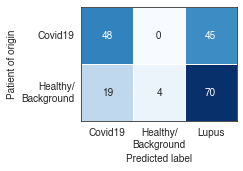


************************************************************

lasso_cv.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.780 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.780 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.783 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.783 +/- 0.000 (in 1 folds)
Accuracy: 0.283 +/- 0.000 (in 1 folds)
MCC: 0.182 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.283
MCC: 0.182

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.72      0.52      0.60        83
Healthy/Background       1.00      0.05      0.09        83
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.28       166
         macro avg       0.57      0.19      0.23       166
      weighted avg       0.86      0.28      0.35       166



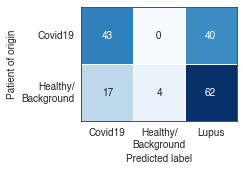


************************************************************

lasso_cv.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.780 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.780 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.783 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.783 +/- 0.000 (in 1 folds)
Accuracy: 0.687 +/- 0.000 (in 1 folds)
MCC: 0.388 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.687
MCC: 0.388

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.66      0.81      0.72        83
               HIV       0.00      0.00      0.00         0
Healthy/Background       0.75      0.57      0.64        83

          accuracy                           0.69       166
         macro avg       0.47      0.46      0.46       166
      weighted avg       0.70      0.69      0.68       166



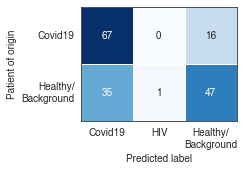


************************************************************

ridge_cv.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.628 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.628 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.667 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.667 +/- 0.000 (in 1 folds)
Accuracy: 0.263 +/- 0.000 (in 1 folds)
MCC: 0.178 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.263
MCC: 0.178

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.73      0.49      0.59        93
Healthy/Background       1.00      0.03      0.06        93
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.26       186
         macro avg       0.58      0.18      0.22       186
      weighted avg       0.87      0.26      0.33       186



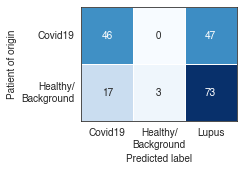


************************************************************

ridge_cv.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.636 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.636 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.676 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.676 +/- 0.000 (in 1 folds)
Accuracy: 0.259 +/- 0.000 (in 1 folds)
MCC: 0.175 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.259
MCC: 0.175

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.73      0.48      0.58        83
Healthy/Background       1.00      0.04      0.07        83
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.26       166
         macro avg       0.58      0.17      0.22       166
      weighted avg       0.86      0.26      0.32       166



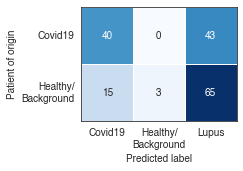


************************************************************

ridge_cv.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.636 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.636 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.676 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.676 +/- 0.000 (in 1 folds)
Accuracy: 0.554 +/- 0.000 (in 1 folds)
MCC: 0.286 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.554
MCC: 0.286

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.88      0.35      0.50        83
               HIV       0.00      0.00      0.00         0
Healthy/Background       0.62      0.76      0.68        83

          accuracy                           0.55       166
         macro avg       0.50      0.37      0.39       166
      weighted avg       0.75      0.55      0.59       166



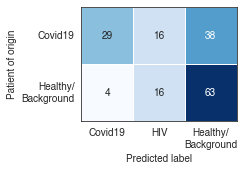


************************************************************

elasticnet_cv.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.680 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.680 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.695 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.695 +/- 0.000 (in 1 folds)
Accuracy: 0.306 +/- 0.000 (in 1 folds)
MCC: 0.207 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.306
MCC: 0.207

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.73      0.53      0.61        93
Healthy/Background       1.00      0.09      0.16        93
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.31       186
         macro avg       0.58      0.20      0.26       186
      weighted avg       0.87      0.31      0.39       186



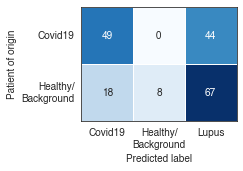


************************************************************

elasticnet_cv.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.690 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.690 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.708 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.708 +/- 0.000 (in 1 folds)
Accuracy: 0.313 +/- 0.000 (in 1 folds)
MCC: 0.213 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.313
MCC: 0.213

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.73      0.53      0.62        83
Healthy/Background       1.00      0.10      0.18        83
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.31       166
         macro avg       0.58      0.21      0.26       166
      weighted avg       0.87      0.31      0.40       166



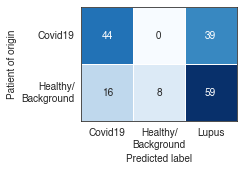


************************************************************

elasticnet_cv.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.690 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.690 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.708 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.708 +/- 0.000 (in 1 folds)
Accuracy: 0.675 +/- 0.000 (in 1 folds)
MCC: 0.373 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.675
MCC: 0.373

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.71      0.66      0.69        83
               HIV       0.00      0.00      0.00         0
Healthy/Background       0.69      0.69      0.69        83

          accuracy                           0.67       166
         macro avg       0.47      0.45      0.46       166
      weighted avg       0.70      0.67      0.69       166



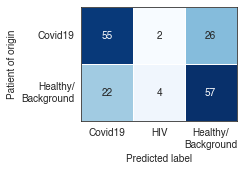


************************************************************

lasso_multiclass.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.656 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.656 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.690 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.690 +/- 0.000 (in 1 folds)
Accuracy: 0.425 +/- 0.000 (in 1 folds)
MCC: 0.184 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.425
MCC: 0.184

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.63      0.85      0.72        93
Healthy/Background       0.00      0.00      0.00        93
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.42       186
         macro avg       0.21      0.28      0.24       186
      weighted avg       0.31      0.42      0.36       186



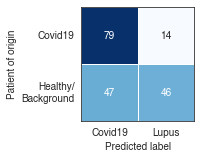


************************************************************

lasso_multiclass.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.646 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.646 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.691 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.691 +/- 0.000 (in 1 folds)
Accuracy: 0.416 +/- 0.000 (in 1 folds)
MCC: 0.173 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.416
MCC: 0.173

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.62      0.83      0.71        83
Healthy/Background       0.00      0.00      0.00        83
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.42       166
         macro avg       0.21      0.28      0.24       166
      weighted avg       0.31      0.42      0.36       166



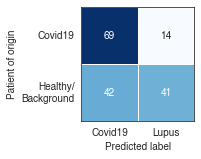


************************************************************

lasso_multiclass.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.646 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.646 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.691 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.691 +/- 0.000 (in 1 folds)
Accuracy: 0.380 +/- 0.000 (in 1 folds)
MCC: 0.177 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.380
MCC: 0.177

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.65      0.76      0.70        83
Healthy/Background       0.00      0.00      0.00        83
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.38       166
         macro avg       0.22      0.25      0.23       166
      weighted avg       0.32      0.38      0.35       166



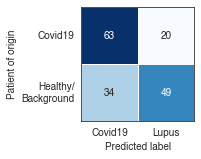


************************************************************

xgboost.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.537 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.537 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.631 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.631 +/- 0.000 (in 1 folds)
Accuracy: 0.129 +/- 0.000 (in 1 folds)
MCC: 0.170 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.129
MCC: 0.170

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.92      0.24      0.38        93
Healthy/Background       1.00      0.02      0.04        93
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.13       186
         macro avg       0.64      0.09      0.14       186
      weighted avg       0.96      0.13      0.21       186



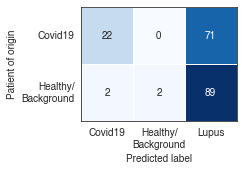


************************************************************

xgboost.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.534 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.534 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.639 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.639 +/- 0.000 (in 1 folds)
Accuracy: 0.114 +/- 0.000 (in 1 folds)
MCC: 0.153 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.114
MCC: 0.153

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.89      0.20      0.33        83
Healthy/Background       1.00      0.02      0.05        83
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.11       166
         macro avg       0.63      0.08      0.13       166
      weighted avg       0.95      0.11      0.19       166



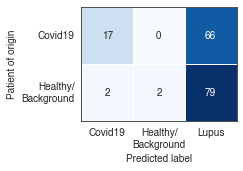


************************************************************

xgboost.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.534 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.534 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.639 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.639 +/- 0.000 (in 1 folds)
Accuracy: 0.783 +/- 0.000 (in 1 folds)
MCC: 0.580 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.783
MCC: 0.580

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.86      0.67      0.76        83
Healthy/Background       0.73      0.89      0.80        83

          accuracy                           0.78       166
         macro avg       0.80      0.78      0.78       166
      weighted avg       0.80      0.78      0.78       166



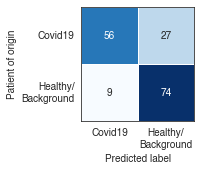


************************************************************

linearsvm_ovr.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.786 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.786 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.765 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.765 +/- 0.000 (in 1 folds)
Accuracy: 0.452 +/- 0.000 (in 1 folds)
MCC: 0.227 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.452
MCC: 0.227

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.65      0.90      0.76        93
Healthy/Background       0.00      0.00      0.00        93
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.45       186
         macro avg       0.22      0.30      0.25       186
      weighted avg       0.33      0.45      0.38       186



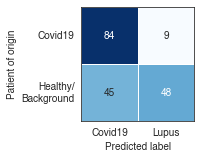


************************************************************

linearsvm_ovr.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.780 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.780 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.761 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.761 +/- 0.000 (in 1 folds)
Accuracy: 0.446 +/- 0.000 (in 1 folds)
MCC: 0.221 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.446
MCC: 0.221

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.65      0.89      0.75        83
Healthy/Background       0.00      0.00      0.00        83
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.45       166
         macro avg       0.22      0.30      0.25       166
      weighted avg       0.32      0.45      0.38       166



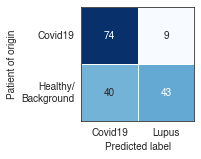


************************************************************

linearsvm_ovr.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.780 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.780 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.761 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.761 +/- 0.000 (in 1 folds)
Accuracy: 0.380 +/- 0.000 (in 1 folds)
MCC: 0.229 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.380
MCC: 0.229

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.72      0.76      0.74        83
Healthy/Background       0.00      0.00      0.00        83
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.38       166
         macro avg       0.24      0.25      0.25       166
      weighted avg       0.36      0.38      0.37       166



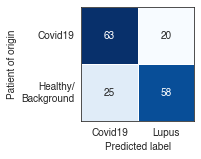


************************************************************

rf_multiclass.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.526 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.526 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.562 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.562 +/- 0.000 (in 1 folds)
Accuracy: 0.371 +/- 0.000 (in 1 folds)
MCC: 0.183 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.371
MCC: 0.183

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.66      0.73      0.69        93
Healthy/Background       1.00      0.01      0.02        93
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.37       186
         macro avg       0.55      0.25      0.24       186
      weighted avg       0.83      0.37      0.36       186



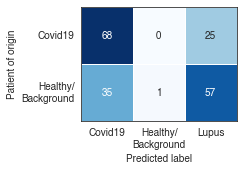


************************************************************

rf_multiclass.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.523 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.523 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.571 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.571 +/- 0.000 (in 1 folds)
Accuracy: 0.367 +/- 0.000 (in 1 folds)
MCC: 0.175 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.367
MCC: 0.175

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.65      0.72      0.69        83
Healthy/Background       1.00      0.01      0.02        83
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.37       166
         macro avg       0.55      0.24      0.24       166
      weighted avg       0.83      0.37      0.35       166



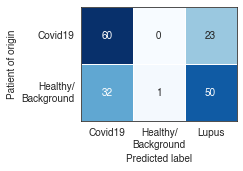


************************************************************

rf_multiclass.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.523 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.523 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.571 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.571 +/- 0.000 (in 1 folds)
Accuracy: 0.645 +/- 0.000 (in 1 folds)
MCC: 0.351 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.645
MCC: 0.351

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.83      0.36      0.50        83
Healthy/Background       0.59      0.93      0.72        83

          accuracy                           0.64       166
         macro avg       0.71      0.64      0.61       166
      weighted avg       0.71      0.64      0.61       166



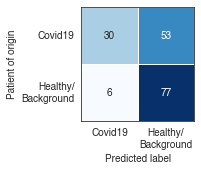


************************************************************



## GeneLocus.BCR|TCR

2023-01-05 13:32:54,152 - evaluate_external_cohorts.ipynb - WARNING - No external cohort specimens found for GeneLocus.BCR|TCR


### (<GeneLocus.TCR: 2>, 'lasso_cv.untuned.all_data')

,TCR:repertoire_stats:Covid19,TCR:repertoire_stats:HIV,TCR:repertoire_stats:Healthy/Background,TCR:repertoire_stats:Lupus,TCR:convergent_cluster_model:Covid19,TCR:convergent_cluster_model:HIV,TCR:convergent_cluster_model:Healthy/Background,TCR:convergent_cluster_model:Lupus,TCR:sequence_model:Covid19,TCR:sequence_model:HIV,TCR:sequence_model:Healthy/Background,TCR:sequence_model:Lupus
specimen_label,,,,,,,,,,,,
BS-EQ-15-T1-replacement_TCRB,0.989645,0.000021,0.000019,0.010315,0.024980,0.038882,0.098958,0.837180,0.262009,0.224203,0.258372,0.255416
BS-EQ-0014-T2-replacement_TCRB,0.537098,0.007406,0.000037,0.455459,0.092543,0.055772,0.364255,0.487430,0.262469,0.233402,0.245773,0.258355
BS-GIGI_55-replacement_TCRB,0.603083,0.001427,0.003031,0.392460,0.033159,0.103950,0.285474,0.577418,0.258620,0.223220,0.255337,0.262823
BS-GN-0005-T0-replacement_TCRB,0.846653,0.000511,0.000014,0.152822,0.055066,0.006366,0.046756,0.891812,0.261867,0.229686,0.249371,0.259075
BS-EQ-0026-T0-replacement_TCRB,0.987303,0.000068,0.000080,0.012549,0.122883,0.049274,0.200523,0.627320,0.262090,0.227350,0.256448,0.254112
...,...,...,...,...,...,...,...,...,...,...,...,...
P00645,0.951086,0.000270,0.000187,0.048457,0.023814,0.015049,0.323151,0.637987,0.257115,0.231441,0.251582,0.259862
P00653,0.386149,0.000105,0.000085,0.613661,0.000003,0.000044,0.075449,0.924505,0.260782,0.227962,0.251718,0.259537
P00660,0.812081,0.010957,0.000191,0.176770,0.000038,0.000494,0.051097,0.948371,0.259292,0.231755,0.247757,0.261197


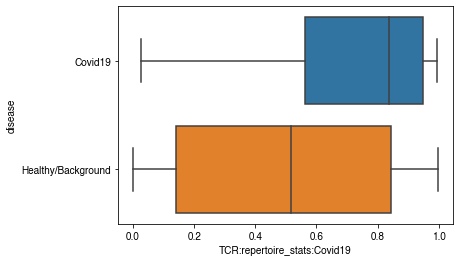

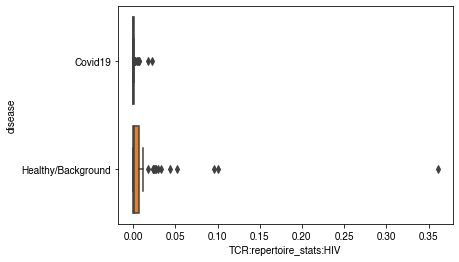

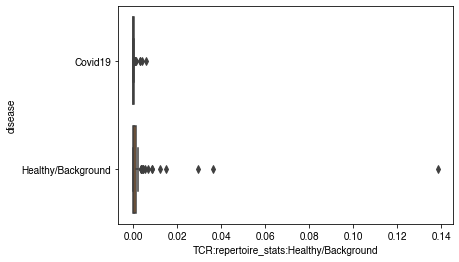

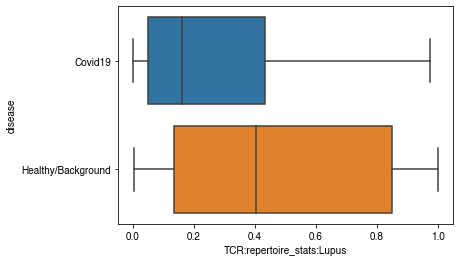

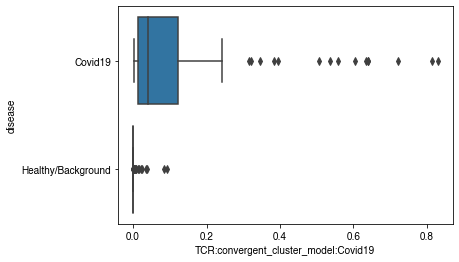

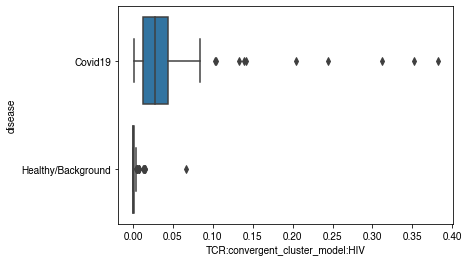

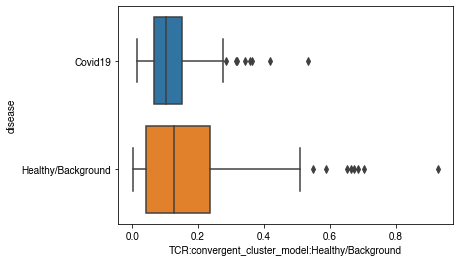

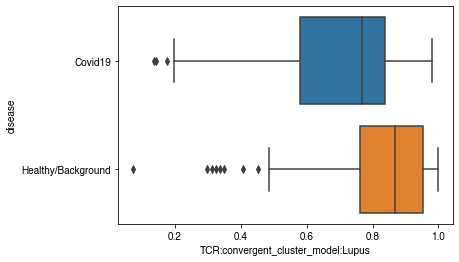

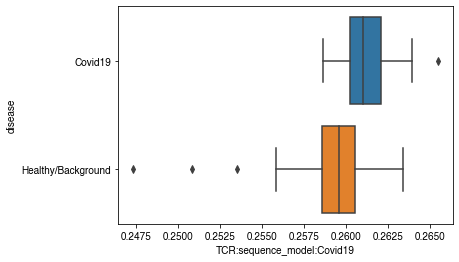

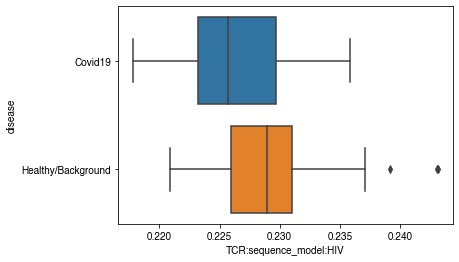

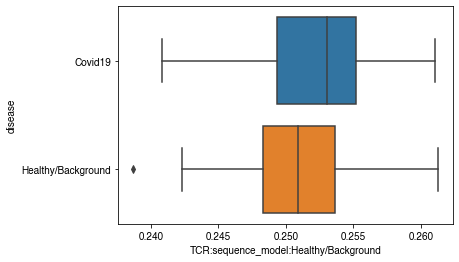

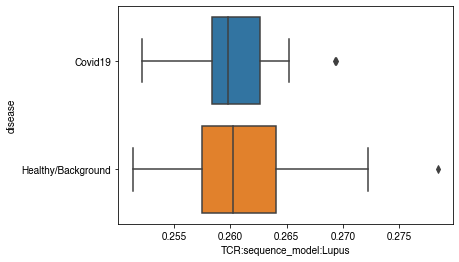

---

In [10]:
featurized_by_gene_locus_and_model_name = kdict()
results_by_gene_locus = {}

for gene_locus in gene_loci:
    # run on single locus
    results, featurized_by_metamodel_name = run(
        gene_locus=gene_locus,
        different_platform=True,
        classification_target=evaluation_target,
        output_dir=config.paths.high_res_outputs_dir
        / "external_cohort_evaluation"
        / "different_platform"
        / gene_locus.name,
    )
    if results is not None:
        results_by_gene_locus[gene_locus] = results
        for metamodel_name, featurized in featurized_by_metamodel_name.items():
            featurized_by_gene_locus_and_model_name[
                gene_locus, metamodel_name
            ] = featurized

if len(gene_loci) > 1:
    # run on multiple loci
    results, featurized_by_metamodel_name = run(
        gene_locus=gene_loci,
        different_platform=True,
        classification_target=evaluation_target,
        output_dir=config.paths.high_res_outputs_dir
        / "external_cohort_evaluation"
        / "different_platform"
        / gene_loci.name,
    )
    if results is not None:
        results_by_gene_locus[gene_loci] = results
        for metamodel_name, featurized in featurized_by_metamodel_name.items():
            featurized_by_gene_locus_and_model_name[
                gene_loci, metamodel_name
            ] = featurized


# Visualize subcomponent predictions
# (Have to use this awkward kdict notation because GeneLocus flag-enum key is not well handled)
any_metamodel_name = featurized_by_gene_locus_and_model_name.keys(dimensions=1)[0]
for key, featurized in featurized_by_gene_locus_and_model_name[
    :, any_metamodel_name
].items():
    gene_locus, _ = key
    output_dir = (
        config.paths.high_res_outputs_dir
        / "external_cohort_evaluation"
        / "different_platform"
        / gene_locus.name
    )
    output_dir.mkdir(parents=True, exist_ok=True)

    display(Markdown(f"### {key}"))
    display(featurized.X)

    for col in featurized.X.columns:
        fig = plt.figure()
        sns.boxplot(
            data=pd.concat([featurized.X[col], featurized.metadata], axis=1),
            x=col,
            y="disease",
        )
        genetools.plots.savefig(
            fig, output_dir / f"subcomponent.{slugify(col)}.png", dpi=300
        )
        display(fig)
        plt.close(fig)
    display(Markdown("---"))